# Can we combine PKN and causal discovery algorithms to build the best graphs?

To test:
- PKN problems
    - Cycles
    - Confounders that are not real
    - Edges that are not real
- Causal discovery problems
    - IDK? cant id all edges
    

In [1]:
from MScausality.simulation import simulate_data

import pandas as pd
import numpy as np
import random
import os
from itertools import permutations, combinations

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag
from sklearn.metrics import roc_curve, roc_auc_score

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from numpyro.ops.indexing import Vindex

import scipy.stats as stats
from statsmodels.formula.api import glm
import statsmodels
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

## Ground Truth Network

In [2]:
def build_igf_network(cell_confounder):
    """
    Create IGF graph in networkx
    
    cell_confounder : bool
        Whether to add in cell type as a confounder
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("EGF", "SOS")
    graph.add_edge("EGF", "PI3K")
    graph.add_edge("IGF", "SOS")
    graph.add_edge("IGF", "PI3K")
    graph.add_edge("SOS", "Ras")
    graph.add_edge("Ras", "PI3K")
    graph.add_edge("Ras", "Raf")
    graph.add_edge("PI3K", "Akt")
    graph.add_edge("Akt", "Raf")
    graph.add_edge("Raf", "Mek")
    graph.add_edge("Mek", "Erk")
    
    if cell_confounder:
        graph.add_edge("cell_type", "Ras")
        graph.add_edge("cell_type", "Raf")
        graph.add_edge("cell_type", "Mek")
        graph.add_edge("cell_type", "Erk")
    
    return graph

def build_admg(graph, cell_confounder=False, cell_latent=False):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk", "EGF", "IGF"]
    obs_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk"]
    latent_nodes = ["EGF", "IGF"]
    
    ## Add in cell_type if included
    if cell_confounder:
        all_nodes.append("cell_type")
        if cell_latent:
            latent_nodes.append("cell_type")
        else:
            obs_nodes.append("cell_type")
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), "hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

In [3]:
cell_type_graph = build_igf_network(cell_confounder=True)
bulk_graph = build_igf_network(cell_confounder=False)
y0_graph_bulk = build_admg(bulk_graph, cell_confounder=False)

In [4]:
## Coefficients for relations
cell_coef = {'EGF': {'intercept': 18., "error": 3},
              'IGF': {'intercept': 17., "error": 3},
              'SOS': {'intercept': -4, "error": 1, 
                      'EGF': 0.6, 'IGF': 0.6,},
              'Ras': {'intercept': 5, "error": 1, 'SOS': .5, "cell_type" : [3, 0, -3]},
              'PI3K': {'intercept': 1.6, "error": 1, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5,},
              'Akt': {'intercept': 2., "error": 1, 'PI3K': 0.75, },
              'Raf': {'intercept': 2, "error": 1,
                      'Ras': 0.8, 'Akt': -.4, "cell_type" : [-2, 0, 2]},
              'Mek': {'intercept': 3., "error": 1, 'Raf': 0.75, "cell_type" : [-2, 0, 2]},
              'Erk': {'intercept': 4., "error": 1, 'Mek': 1.2, "cell_type" : [-2, 0, 2]}
             }

## Simulate Data

In [5]:
high_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=250, seed=0)

simulating data...
adding feature level data...
masking data...


In [4]:
high_rep_protein_data = pd.read_csv("../data/IGF_pathway/high_rep_protein_data.csv")

In [5]:
obs_nodes = ["SOS", "Ras", "PI3K", "Akt", "Raf", "Mek", "Erk"]
sim_data = high_rep_protein_data.loc[:, [i for i in high_rep_protein_data.columns if i in obs_nodes]]

In [6]:
sim_data.head()

,Akt,Erk,Mek,PI3K,Raf,Ras,SOS
0,23.969979,11.224650,6.526167,31.478477,4.763532,16.535875,20.768065
1,20.683893,10.208765,5.825186,25.695140,2.056831,11.678421,15.921744
2,23.370741,13.598498,7.190195,28.245723,NaN,15.520199,19.385712
3,24.709821,9.423789,4.543260,30.625808,4.140143,16.823690,19.496722
4,24.132113,12.086784,6.032821,31.108506,3.109953,15.629812,20.531045


## Simulate INDRA Graph

### Analysis of INDRA edges

In [2]:
network_dir = "../data/INDRA_networks/"
gene_sets = dict()

files = os.listdir(network_dir)
for filename in files:    
    gene_set_name = filename.split(".")[0]
    gene_sets[gene_set_name] = pd.read_csv(os.path.join(network_dir, filename), 
                                           sep="\t").loc[:, ["source_hgnc_symbol", "target_hgnc_symbol", "evidence_count"]]

/tmp/ipykernel_86/4276871422.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_sets[gene_set_name] = pd.read_csv(os.path.join(network_dir, filename),
/tmp/ipykernel_86/4276871422.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_sets[gene_set_name] = pd.read_csv(os.path.join(network_dir, filename),


In [3]:
for key, val in gene_sets.items():
    print(key)
    print(len(val))

ADA2_TARGET_GENES
29633
ADCYAP1_TARGET_GENES
13
ADNP_TARGET_GENES
29828
HALLMARK_CHOLESTEROL_HOMEOSTASIS
13324
HALLMARK_HYPOXIA
69314
HALLMARK_MITOTIC_SPINDLE
12853
HALLMARK_TNFA_SIGNALING_VIA_NFKB
114490
HALLMARK_WNT_BETA_CATENIN_SIGNALING
25768


/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

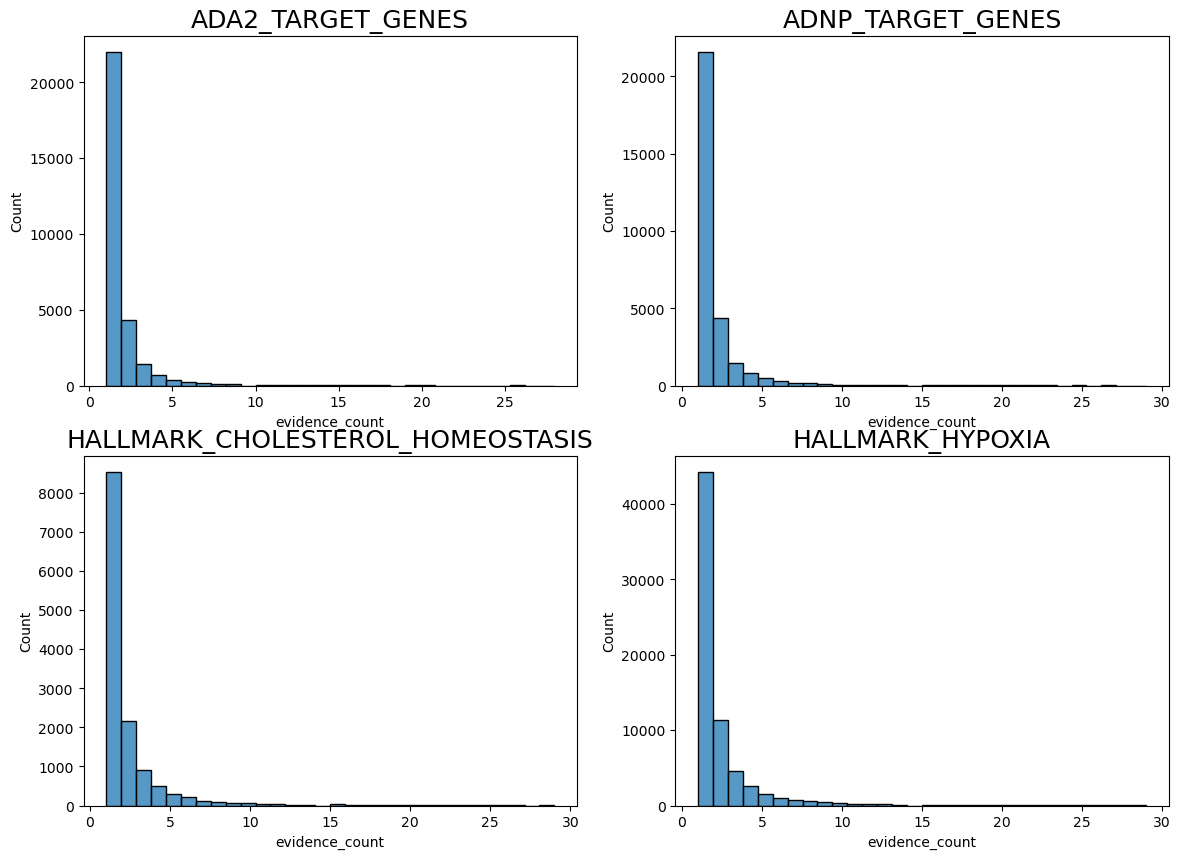

In [95]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
count = 0
i=0
j=0
for key, val in gene_sets.items():
    sns.histplot(val[val["evidence_count"] < 30]["evidence_count"], bins=30, ax=ax[i, j])
    ax[i, j].set_title(key, size=18)
    
    if j == 1:
        i+=1
        j=0
    else:
        j+=1
    if count < 3:
        count +=1
    else:
        break
    

In [18]:
mcmc = MCMC(NUTS(model), num_warmup=5000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(69), gene_sets['HALLMARK_CHOLESTEROL_HOMEOSTASIS']["evidence_count"].values - 1, len(gene_sets['HALLMARK_CHOLESTEROL_HOMEOSTASIS']))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [19]:
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
    edge_probs[0]      0.50      0.29      0.50      0.00      0.90   5654.65      1.00
    edge_probs[1]      0.49      0.28      0.49      0.00      0.89   5202.40      1.00
    edge_probs[2]      0.51      0.29      0.50      0.04      0.93   5735.58      1.00
    edge_probs[3]      0.49      0.29      0.49      0.02      0.91   6353.86      1.00
    edge_probs[4]      0.50      0.29      0.50      0.08      0.98   5103.83      1.00
    edge_probs[5]      0.50      0.29      0.50      0.07      0.96   5986.35      1.00
    edge_probs[6]      0.50      0.29      0.51      0.09      0.99   6566.13      1.00
    edge_probs[7]      0.50      0.28      0.50      0.07      0.96   5834.15      1.00
    edge_probs[8]      0.49      0.29      0.49      0.02      0.91   5236.47      1.00
    edge_probs[9]      0.50      0.29      0.50      0.08      0.97   6392.16      1.00
   edge_probs[10]      0.50    

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Edge probability')

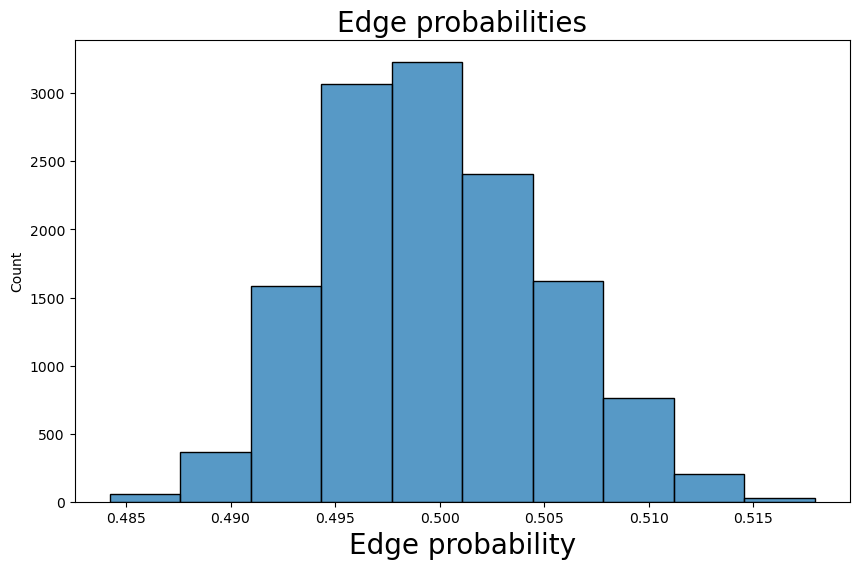

In [20]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(mcmc.get_samples()['edge_probs'].mean(axis=0), bins=10)
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge probability", size=20)

In [57]:
id_edges = gene_sets['HALLMARK_CHOLESTEROL_HOMEOSTASIS'][np.array(mcmc.get_samples()['edge_probs'].mean(axis=0) > 0.513)].reset_index(drop=True)

In [58]:
G = nx.DiGraph()
indra_edges = id_edges.reset_index(drop=True)
for i in range(len(id_edges)):
    G.add_edge(id_edges.loc[i, "source_hgnc_symbol"],
                   id_edges.loc[i, "target_hgnc_symbol"])
#     , latent=id_edges.loc[i, "color"])
# colors = nx.get_edge_attributes(G,'latent').values()

In [59]:
len(G.nodes)

85

In [60]:
len(G.edges)

76

Text(0.5, 1.0, "Model defined 'Real' edges")

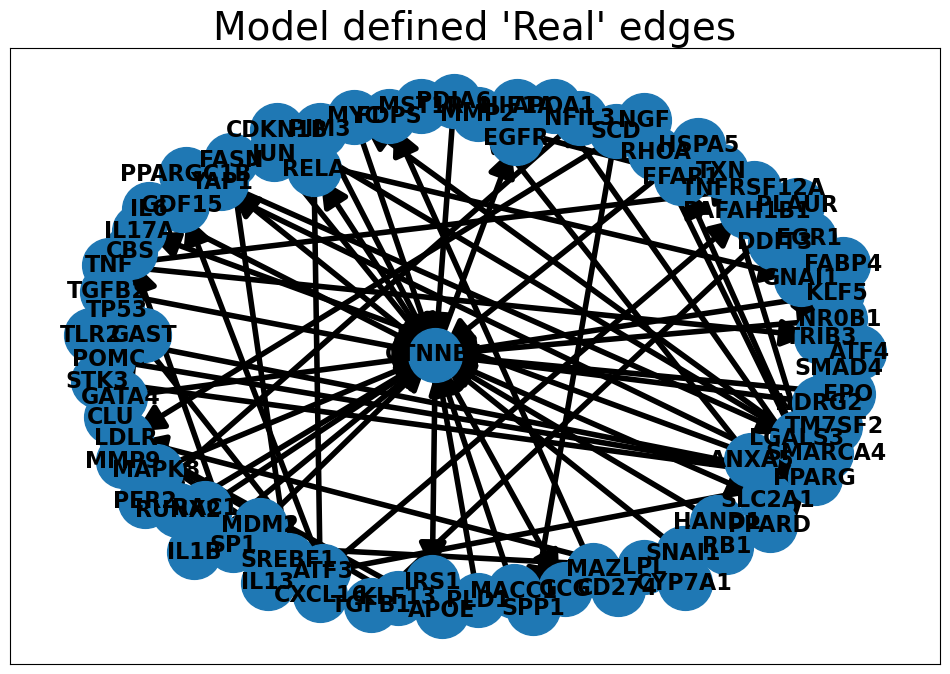

In [61]:
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="black", arrows=True, width=4, arrowsize=40)

ax.set_title("Model defined 'Real' edges", size=28)

In [62]:
[i for i in nx.simple_cycles(G)]

[['PPARG', 'FABP4'], ['MYC', 'CTNNB1', 'YAP1', 'LGALS3']]

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

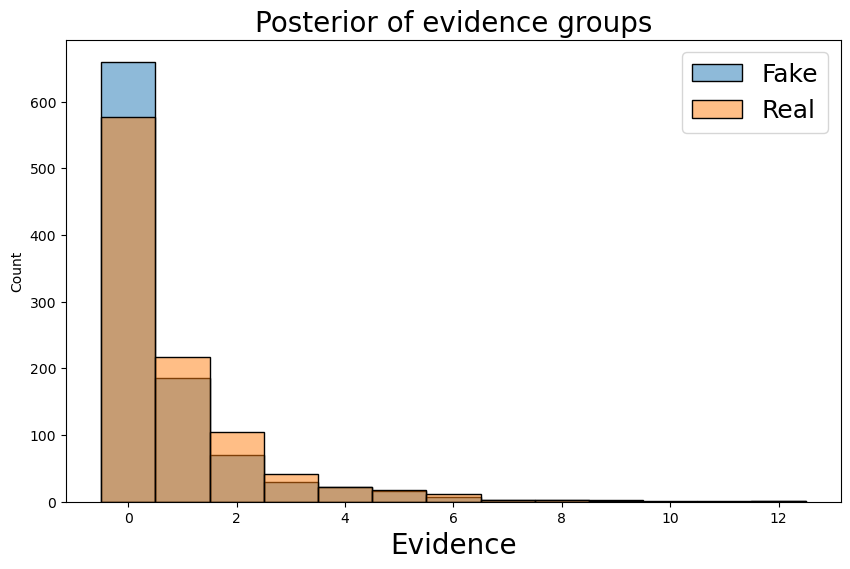

In [21]:
means = mcmc.get_samples()['p_A'].mean(axis=0)
variances = mcmc.get_samples()['p_B'].mean(axis=0)

fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(np.random.poisson(np.random.gamma(means[0], 1/variances[0], 1000)), ax=ax, discrete=True, alpha=.5, label="Fake")
sns.histplot(np.random.poisson(np.random.gamma(means[1], 1/variances[1], 1000)), ax=ax, discrete=True, alpha=.5, label="Real")
ax.set_title("Posterior of evidence groups", size=20)
ax.set_xlabel("Evidence", size=20)
plt.legend(fontsize=18)

In [245]:
import statsmodels.formula.api as smf

In [253]:
mod = smf.glm(formula='index ~ evidence_count', 
              data=gene_sets['HALLMARK_MITOTIC_SPINDLE']["evidence_count"].value_counts().reset_index(), 
              family=sm.families.Gamma(link=sm.families.links.log()))

In [254]:
results = mod.fit()

In [255]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  index   No. Observations:                   36
Model:                            GLM   Df Residuals:                       34
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                         0.89565
Method:                          IRLS   Log-Likelihood:                -148.73
Date:                Tue, 31 Oct 2023   Deviance:                       25.220
Time:                        13:34:55   Pearson chi2:                     30.5
No. Iterations:                    17   Pseudo R-squ. (CS):             0.1867
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.2876      0.162     20.324      0.000       2.971       3.605
evidence_count    -0.0004      0.000     -3.734      0.000      -0.001      -0.000
==================================================================================
"""

### Simulate

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

Text(0.5, 0, 'Evidence')

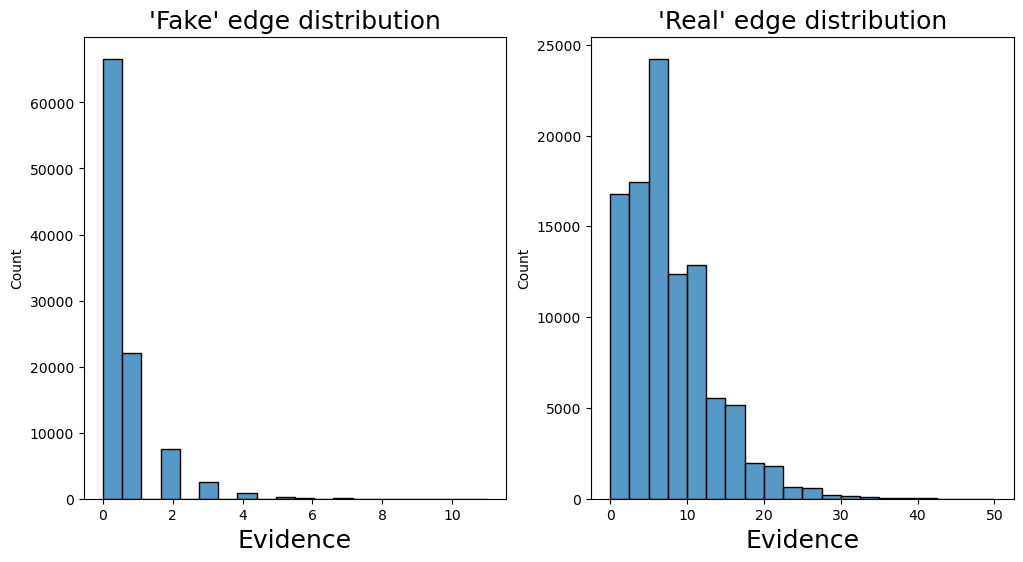

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

# ax[0].hist(stats.nbinom.rvs(1, .5, size=1000000), bins=30)
# ax[1].hist(stats.nbinom.rvs(3,.25, size=1000000), bins=30)

sns.histplot(np.random.poisson(np.random.gamma(1, .5, 100000)), bins=20, ax=ax[0])
sns.histplot(np.random.poisson(np.random.gamma(2.5, 3, 100000)), bins=20, ax=ax[1])

ax[0].set_title("'Fake' edge distribution", size=18)
ax[1].set_title("'Real' edge distribution", size=18)

ax[0].set_xlabel("Evidence", size=18)
ax[1].set_xlabel("Evidence", size=18)

In [8]:
real_edges = pd.DataFrame({"From": ["EGF", "EGF", "IGF", "IGF", "SOS", "Ras", "Ras", "PI3K", "Akt", "Raf", "Mek"],
                           "To": ["SOS", "PI3K", "SOS", "PI3K", "Ras", "PI3K", "Raf", "Akt", "Raf", "Mek", "Erk"],
                           "evidence": np.random.poisson(np.random.gamma(2.5, 3, 11))})

real_edges.loc[:, "real"] = True
real_edges

,From,To,evidence,real
0,EGF,SOS,0,True
1,EGF,PI3K,3,True
2,IGF,SOS,8,True
3,IGF,PI3K,2,True
4,SOS,Ras,11,True
5,Ras,PI3K,10,True
6,Ras,Raf,4,True
7,PI3K,Akt,20,True
8,Akt,Raf,12,True
9,Raf,Mek,14,True


In [9]:
nodes = ["SOS", "Ras", "PI3K", "Akt", "Raf", "Mek", "Erk", "EGF", "IGF"]
obs_nodes = ["SOS", "Ras", "PI3K", "Akt", "Raf", "Mek", "Erk"]
fake_confounders = ["C1" , "C2", "C3"]

In [12]:
all_nodes = ["SOS", "Ras", "PI3K", "Akt", "Raf", "Mek", "Erk", "EGF", "IGF", "C1" , "C2", "C3"]
potential_edges = permutations(all_nodes, 2)
indra_graph = real_edges

for i in potential_edges:
    
    lookup = real_edges.loc[(real_edges["From"] == i[0]) & (real_edges["To"] == i[1])]
    sample = np.random.uniform(0,1)
    
    if (len(lookup) == 0) & (sample > .6):
        indra_graph = pd.concat([indra_graph, pd.DataFrame(
            {"From": [i[0]], "To": [i[1]], "evidence": stats.nbinom.rvs(1,.5, size=1), "real": False})],
                               ignore_index=True)

Remove 0 evidence edges

In [13]:
# indra_graph = indra_graph[indra_graph["evidence"] > 0].reset_index(drop=True)

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

Text(0.5, 0, 'Evidence')

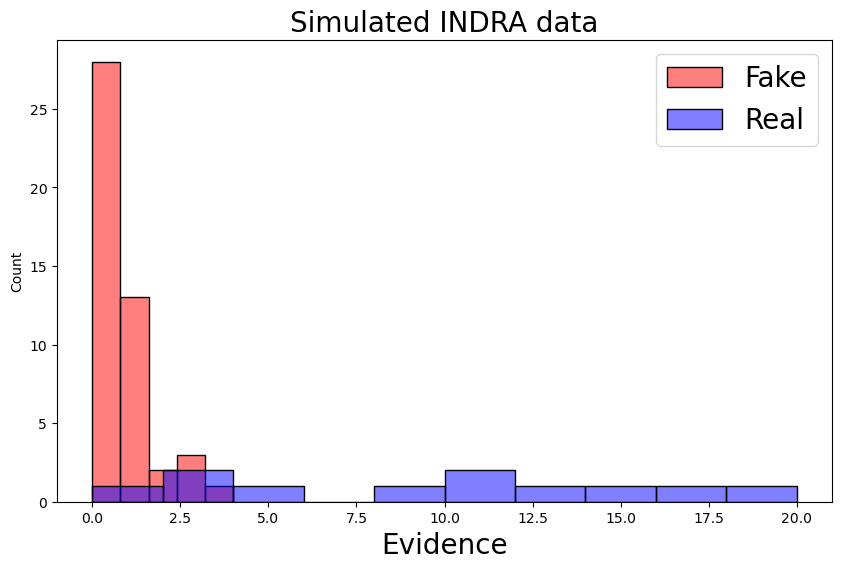

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(indra_graph[indra_graph["real"] == False]["evidence"], color="red", bins=5, alpha=.5, label="Fake", ax=ax)
sns.histplot(indra_graph[indra_graph["real"] == True]["evidence"], color="blue", bins=10, alpha=.5, label="Real", ax=ax)

plt.legend(fontsize=20)
ax.set_title("Simulated INDRA data", size=20)
ax.set_xlabel("Evidence", size=20)

In [15]:
indra_graph

,From,To,evidence,real
0,EGF,SOS,0,True
1,EGF,PI3K,3,True
2,IGF,SOS,8,True
3,IGF,PI3K,2,True
4,SOS,Ras,11,True
5,Ras,PI3K,10,True
6,Ras,Raf,4,True
7,PI3K,Akt,20,True
8,Akt,Raf,12,True
9,Raf,Mek,14,True


In [889]:
indra_graph.loc[:, "confound_edge"] = False
indra_graph.loc[:, "From_latent"] = indra_graph.loc[:, "From"].apply(lambda x: False if x in obs_nodes else True)

for i in indra_graph[indra_graph["From_latent"] == True]["From"].unique():
    
    confounded_nodes = combinations(indra_graph[indra_graph["From"] == i]["To"].unique(), 2)
    confound_temp_df = pd.DataFrame(confounded_nodes, columns=["From", "To"])
    evidence_tracker = list()
    real_tracker = list()
    for row in range(len(confound_temp_df)):
        
        nodes = confound_temp_df.loc[row,:].values
        temp_evidence = round(indra_graph[(indra_graph["From"] == i) & (indra_graph["To"].isin(nodes))]["evidence"].mean())
        evidence_tracker.append(temp_evidence)
        if ((i == "IGF") | (i == "EGF")) & (("SOS" in nodes) & ("PI3K" in nodes)):
            real_tracker.append(True)
        else:
            real_tracker.append(False)
    
    confound_temp_df.loc[:, "evidence"] = evidence_tracker
    confound_temp_df.loc[:, "real"] = real_tracker
    
    confound_temp_df.loc[:, "From_latent"] = False
    confound_temp_df.loc[:, "confound_edge"] = True
    
    indra_graph = pd.concat([indra_graph, confound_temp_df], ignore_index=True)
    

In [890]:
indra_graph = indra_graph[indra_graph["From_latent"] == False]

In [891]:
indra_graph[indra_graph["real"] == True]

,From,To,evidence,real,confound_edge,From_latent
4,SOS,Ras,15,True,False,False
5,Ras,PI3K,14,True,False,False
6,Ras,Raf,14,True,False,False
7,PI3K,Akt,11,True,False,False
8,Akt,Raf,9,True,False,False
9,Raf,Mek,19,True,False,False
10,Mek,Erk,9,True,False,False
53,SOS,PI3K,4,True,True,False
68,SOS,PI3K,7,True,True,False


## Models

### Data-only

In [10]:
obs_nodes = ["SOS", "Ras", "PI3K", "Akt", "Raf", "Mek", "Erk"]
potential_edges = permutations(obs_nodes, 2)

In [11]:
G = nx.DiGraph()
for i in potential_edges:
    G.add_edge(i[0], i[1])

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


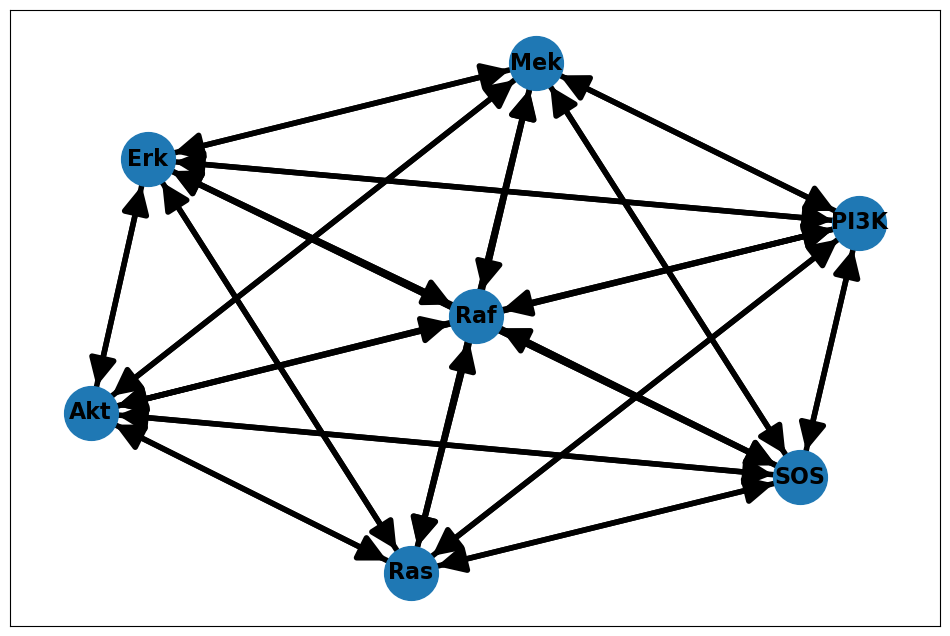

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, width=4, arrowsize=40, node_size = 1500)

In [41]:
corr_mat = abs(sim_data.corr())
corr_mat = corr_mat.stack().reset_index()
corr_mat.columns = ["From", "To", "Correlation"]
corr_mat = corr_mat.loc[-(corr_mat["From"] == corr_mat["To"])].reset_index(drop=True)

In [42]:
true_edges = [("SOS", "Ras"), ("Ras", "PI3K"), 
              ("PI3K", "Akt"), ("Ras", "Raf"), 
              ("Akt", "Raf"), ("Raf", "Mek"),
              ("Mek", "Erk")]

In [43]:
for i in range(len(corr_mat)):
    e = (corr_mat.loc[i, "From"], corr_mat.loc[i, "To"])
    if e in true_edges:
        corr_mat.loc[i, "e"] = True
    else:
        corr_mat.loc[i, "e"] = False
corr_mat.head()

/tmp/ipykernel_230/2332461338.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  corr_mat.loc[i, "e"] = False


,From,To,Correlation,e
0,Akt,Erk,0.010365,False
1,Akt,Mek,0.085768,False
2,Akt,PI3K,0.895637,False
3,Akt,Raf,0.063360,True
4,Akt,Ras,0.755017,False


/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of protein correlation')

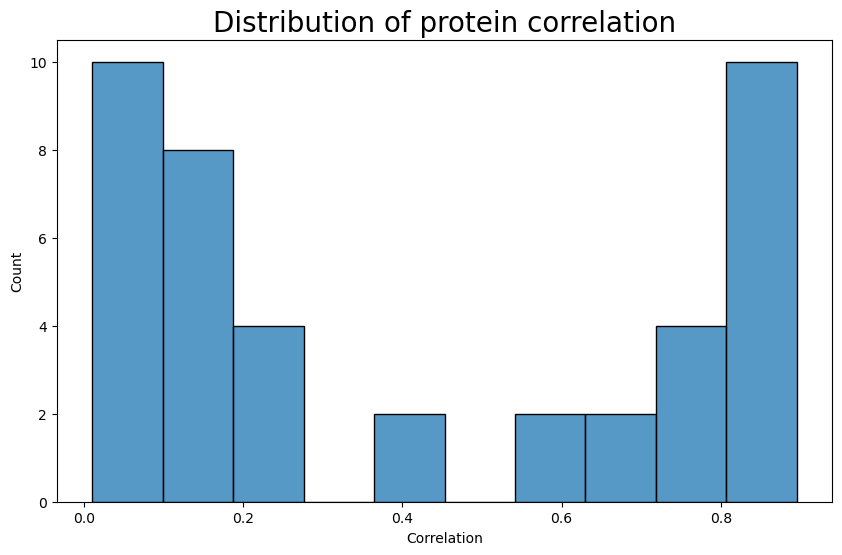

In [27]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(corr_mat["Correlation"], bins=10)
ax.set_title("Distribution of protein correlation", size=20)

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

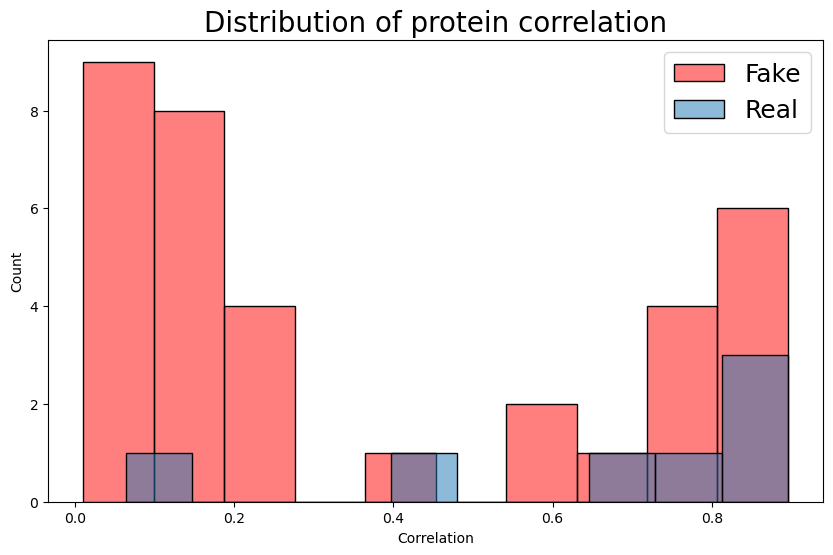

In [37]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(corr_mat[corr_mat["e"] == False]["Correlation"], bins=10, color="r", alpha=.5, label="Fake")
sns.histplot(corr_mat[corr_mat["e"] == True]["Correlation"], bins=10, alpha=.5, label="Real")
ax.set_title("Distribution of protein correlation", size=20)
plt.legend(fontsize=18)
# hist(alpha= .5)
# corr_mat[corr_mat["e"] == False]["Correlation"].hist(color="r", alpha= .5)

In [38]:
def model(data, n_edges):
    
    p_A = numpyro.sample("p_A", dist.Normal(jnp.array([-2, -.5]), jnp.array([.5, .5])).to_event(1))
    p_B = numpyro.sample("p_B", dist.Normal(jnp.array([1, 1]), jnp.array([.25,.25])).to_event(1))
        
    with numpyro.plate("data_plate", n_edges):
        edge_priors = numpyro.sample("edge_probs", dist.Beta(1, 1))

        present_sample = numpyro.sample("sample_edge", 
                                        dist.Bernoulli(edge_priors),
                                       infer={'enumerate': 'parallel'})

        numpyro.sample("indra_evidence", dist.LogNormal(Vindex(p_A)[present_sample],
                                                        Vindex(p_B)[present_sample]), 
                       obs=data)
    

In [39]:
mcmc = MCMC(NUTS(model), num_warmup=3000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(69), corr_mat["Correlation"].values, len(corr_mat))

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [40]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 edge_probs[0]      0.33      0.23      0.29      0.00      0.67   7832.27      1.00
 edge_probs[1]      0.33      0.23      0.30      0.00      0.67   7056.22      1.00
 edge_probs[2]      0.66      0.24      0.70      0.30      1.00   6929.23      1.00
 edge_probs[3]      0.33      0.24      0.29      0.00      0.69   6928.65      1.00
 edge_probs[4]      0.66      0.24      0.69      0.31      1.00   5829.07      1.00
 edge_probs[5]      0.66      0.24      0.70      0.29      1.00   7247.01      1.00
 edge_probs[6]      0.34      0.23      0.30      0.00      0.68   6629.40      1.00
 edge_probs[7]      0.66      0.24      0.70      0.31      1.00   6648.29      1.00
 edge_probs[8]      0.33      0.23      0.29      0.00      0.68   7750.19      1.00
 edge_probs[9]      0.49      0.28      0.48      0.00      0.88   4752.29      1.00
edge_probs[10]      0.33      0.24      0.29      0.00      0.68

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Edge probability')

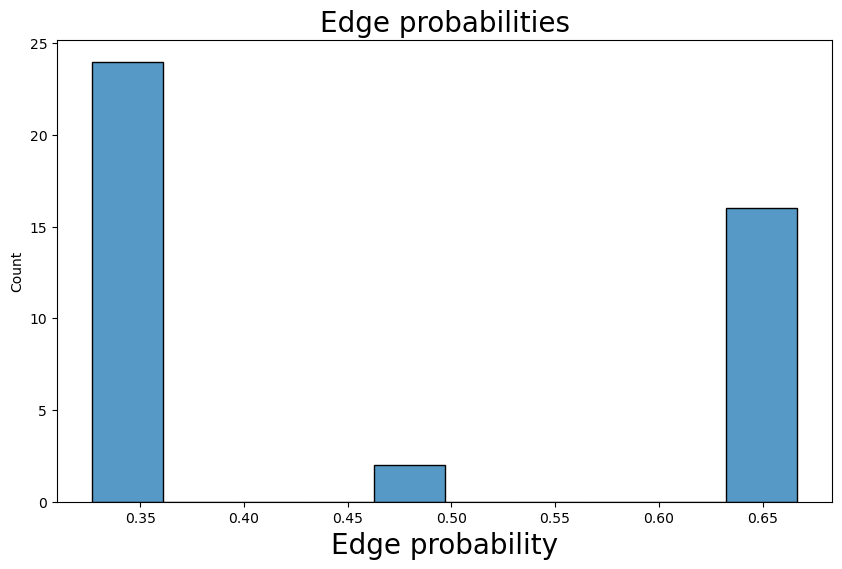

In [44]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(mcmc.get_samples()['edge_probs'].mean(axis=0), bins=10)
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge probability", size=20)

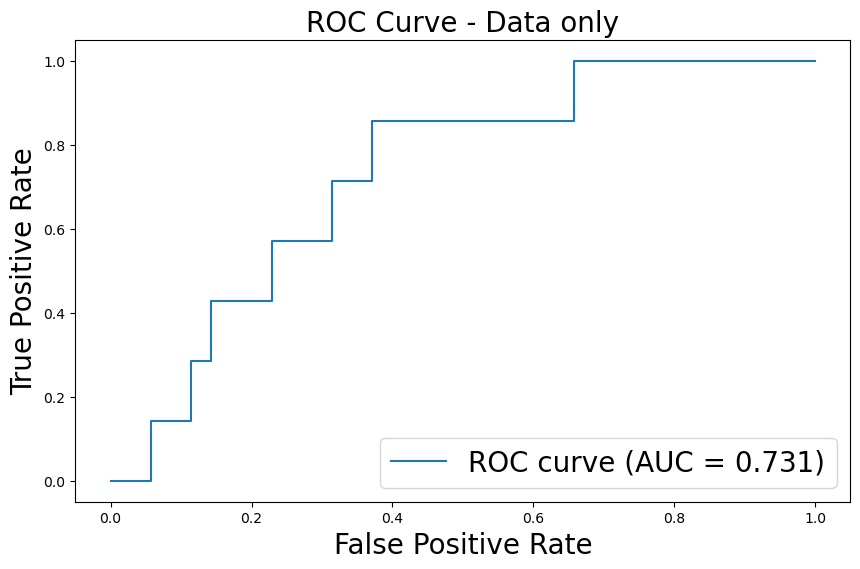

In [49]:
# Generate some data
y_true = corr_mat["e"].values.astype(float)
y_score = np.array(mcmc.get_samples()['edge_probs'].mean(axis=0))

fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC
auc_score = roc_auc_score(y_true, y_score)

# Plot the ROC curve
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(fpr, tpr, label='ROC curve (AUC = %.3f)' % auc_score)
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.title('ROC Curve - Data only', size=20)
plt.legend(loc='lower right', fontsize=20)
plt.show()

In [543]:
fpr, tpr, thresholds 

(array([0.        , 0.        , 0.02857143, 0.02857143, 0.2       ,
        0.2       , 0.28571429, 0.28571429, 0.45714286, 0.45714286,
        0.51428571, 0.51428571, 1.        ]),
 array([0.        , 0.14285714, 0.14285714, 0.28571429, 0.28571429,
        0.42857143, 0.42857143, 0.71428571, 0.71428571, 0.85714286,
        0.85714286, 1.        , 1.        ]),
 array([1.6640835 , 0.6640834 , 0.66192144, 0.6615149 , 0.6579974 ,
        0.65758735, 0.65302396, 0.6456916 , 0.33669755, 0.33627206,
        0.3349662 , 0.33470842, 0.32599485], dtype=float32))

In [50]:
id_edges = corr_mat[np.array(mcmc.get_samples()['edge_probs'].mean(axis=0) > .5)].reset_index(drop=True)

In [51]:
id_edges

,From,To,Correlation,e
0,Akt,PI3K,0.895637,False
1,Akt,Ras,0.755017,False
2,Akt,SOS,0.796230,False
3,Erk,Mek,0.850624,False
4,Mek,Erk,0.850624,True
5,Mek,Raf,0.706171,False
6,PI3K,Akt,0.895637,True
7,PI3K,Ras,0.840267,False
8,PI3K,SOS,0.882309,False
9,Raf,Mek,0.706171,True


In [52]:
G = nx.DiGraph()
for i in range(len(id_edges)):
    G.add_edge(id_edges.loc[i, "From"], id_edges.loc[i, "To"])

Text(0.5, 1.0, "Model defined 'Real' edges")

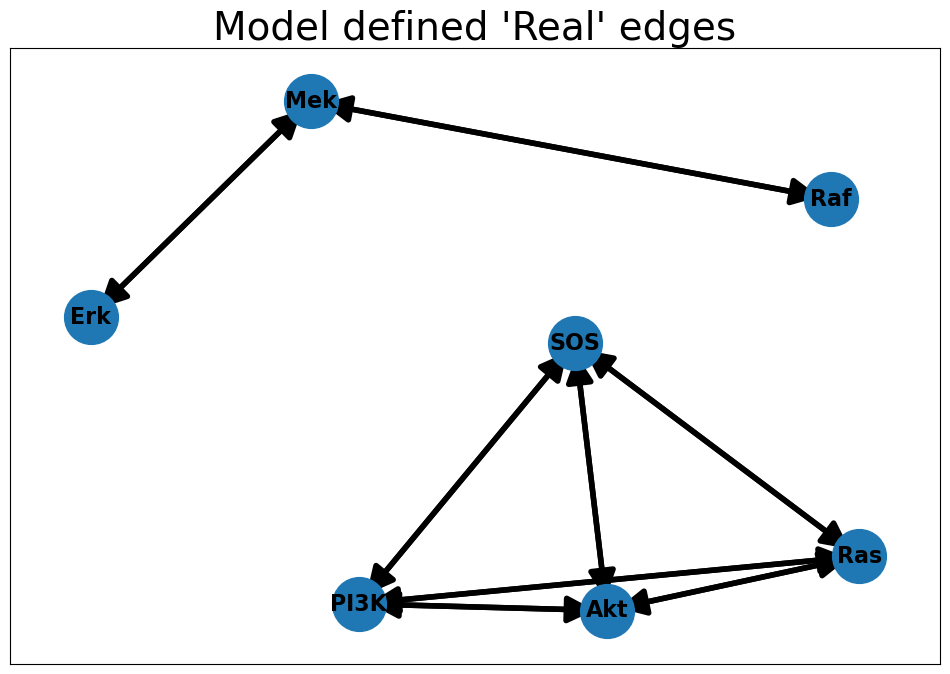

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, width=4, arrowsize=40)

ax.set_title("Model defined 'Real' edges", size=28)

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

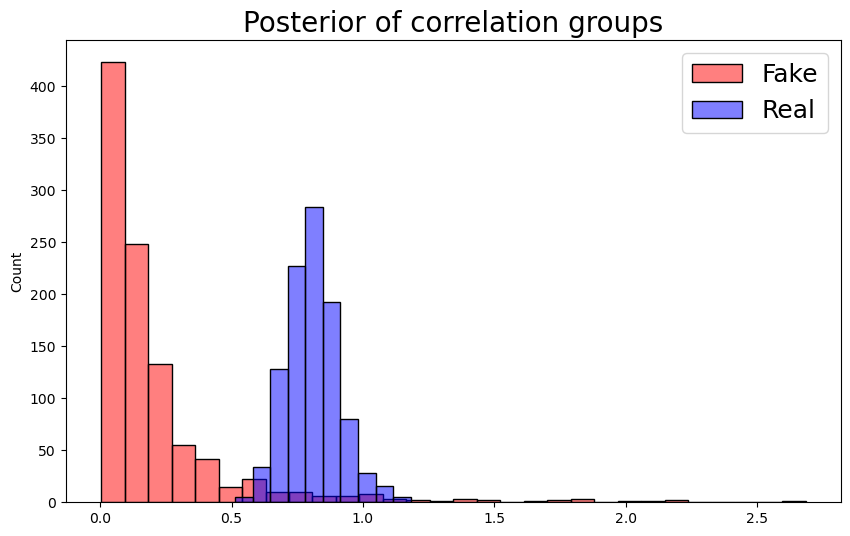

In [64]:
means = mcmc.get_samples()['p_A'].mean(axis=0)
variances = mcmc.get_samples()['p_B'].mean(axis=0)

# d1 = np.random.lognormal(means[0], variances[0], size=1000)
# d2 = np.random.lognormal(means[1], variances[1], size=1000)

fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(d1, color="red", bins=30, alpha=.5, label="Fake")
sns.histplot(d2, color="blue", bins=10, alpha=.5, label="Real")

ax.set_title("Posterior of correlation groups", size=20)
plt.legend(fontsize=18)

### INDRA-only

In [919]:
indra_graph.loc[:, "color"] = np.where(indra_graph["confound_edge"], "r", "black")
indra_graph.loc[:, "size"] = np.where(indra_graph["confound_edge"], "--", "-")

In [920]:
indra_graph

,From,To,evidence,real,confound_edge,From_latent,color,size
4,SOS,Ras,15,True,False,False,black,-
5,Ras,PI3K,14,True,False,False,black,-
6,Ras,Raf,14,True,False,False,black,-
7,PI3K,Akt,11,True,False,False,black,-
8,Akt,Raf,9,True,False,False,black,-
...,...,...,...,...,...,...,...,...
83,C2,C3,1,False,True,False,r,--
84,IGF,C1,0,False,True,False,r,--
85,IGF,C3,1,False,True,False,r,--
86,C1,C3,0,False,True,False,r,--


In [86]:
G = nx.DiGraph()
indra_edges = indra_graph.reset_index(drop=True)
for i in range(len(indra_edges)):
    G.add_edge(indra_edges.loc[i, "From"],
                   indra_edges.loc[i, "To"])
#                        , latent=indra_edges.loc[i, "color"],
#               size=indra_edges.loc[i, "size"])
# colors = nx.get_edge_attributes(G,'latent').values()


/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


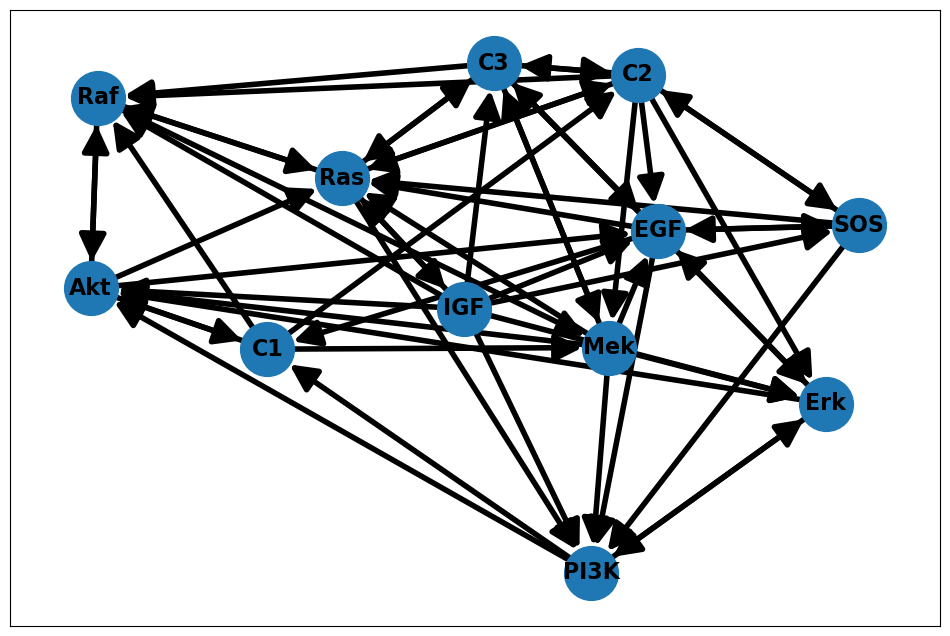

In [87]:
# colors = nx.get_edge_attributes(G,'latent').values()
# size = nx.get_edge_attributes(G,'size').values()

fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="black",arrows=True, width=4, arrowsize=40,  node_size = 1500)

In [866]:
[i for i in nx.simple_cycles(G)]

[['PI3K', 'Erk', 'Mek', 'Raf', 'Akt', 'SOS'],
 ['PI3K', 'Erk', 'Mek', 'Raf', 'Akt', 'SOS', 'Ras'],
 ['PI3K', 'Erk', 'Mek', 'Raf'],
 ['PI3K', 'Erk', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Mek', 'Raf'],
 ['PI3K', 'Erk', 'SOS', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Raf', 'Akt', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Raf'],
 ['PI3K', 'Erk', 'SOS', 'Raf', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Akt', 'Mek', 'Raf'],
 ['PI3K', 'Erk', 'SOS', 'Akt', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Akt', 'Raf'],
 ['PI3K', 'Erk', 'SOS', 'Akt', 'Raf', 'Mek'],
 ['PI3K', 'Erk', 'SOS'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Akt', 'Mek', 'Raf'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Akt', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Akt', 'Raf'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Akt', 'Raf', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Mek', 'Raf'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Raf', 'Akt', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Raf'],
 ['PI3K', 'Erk', 'SOS', 'Ras', 'Raf', 'Mek'],
 ['PI3K', 'Erk', 'SOS', 'Ras'],
 ['PI3K'

In [24]:
def model(data, n_edges):
        
    p_A = numpyro.sample("p_A", dist.LogNormal(jnp.array([1, 5]), jnp.array([.5, .5])).to_event(1))
    p_B = numpyro.sample("p_B", dist.LogNormal(jnp.array([.5, .5]), jnp.array([.25,.25])).to_event(1))
    
    with numpyro.plate("data_plate", n_edges):
        edge_priors = numpyro.sample("edge_probs", dist.Beta(1, 1))

        present_sample = numpyro.sample("sample_edge", 
                                        dist.Bernoulli(edge_priors),
                                       infer={'enumerate': 'parallel'})

        numpyro.sample("indra_evidence", dist.GammaPoisson(Vindex(p_A)[present_sample],
                                                           Vindex(p_B)[present_sample]), obs=data)
    

In [153]:
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), indra_graph["evidence"].values, len(indra_graph))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [90]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 edge_probs[0]      0.57      0.28      0.60      0.16      1.00   6711.47      1.00
 edge_probs[1]      0.67      0.23      0.71      0.32      1.00   6583.81      1.00
 edge_probs[2]      0.67      0.23      0.71      0.33      1.00   7212.31      1.00
 edge_probs[3]      0.56      0.28      0.59      0.16      1.00   7041.80      1.00
 edge_probs[4]      0.66      0.23      0.70      0.32      1.00   7079.40      1.00
 edge_probs[5]      0.65      0.25      0.70      0.28      1.00   7338.69      1.00
 edge_probs[6]      0.62      0.27      0.67      0.22      1.00   7111.77      1.00
 edge_probs[7]      0.67      0.23      0.71      0.33      1.00   7218.04      1.00
 edge_probs[8]      0.66      0.24      0.70      0.30      1.00   7373.43      1.00
 edge_probs[9]      0.67      0.24      0.72      0.32      1.00   8102.32      1.00
edge_probs[10]      0.67      0.24      0.71      0.31      1.00

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Edge probability')

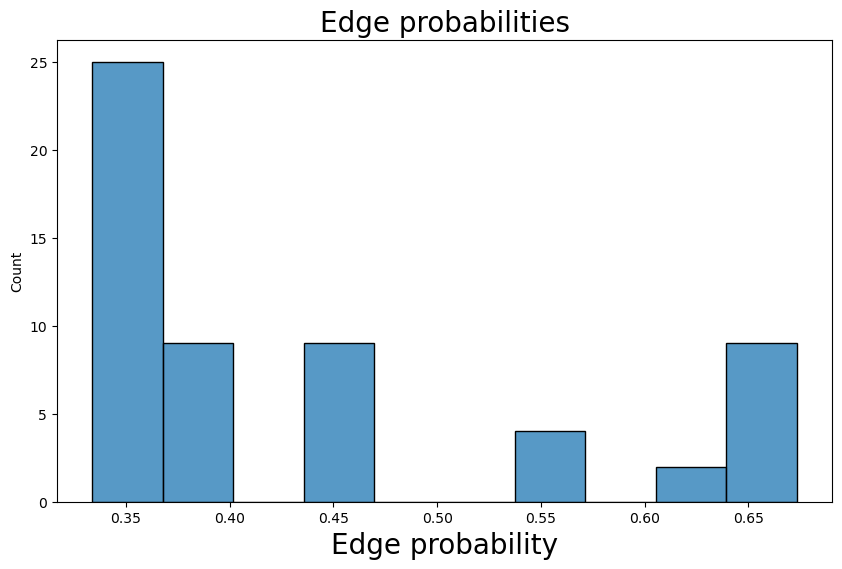

In [155]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(mcmc.get_samples()['edge_probs'].mean(axis=0), bins=10)
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge probability", size=20)

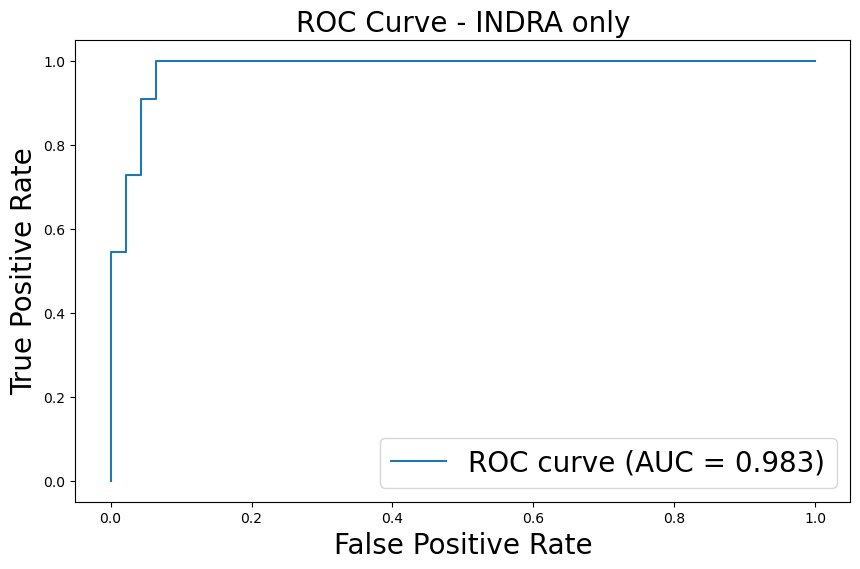

In [93]:
# Generate some data
y_true = indra_graph["real"].values.astype(float)
y_score = np.array(mcmc.get_samples()['edge_probs'].mean(axis=0))

fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC
auc_score = roc_auc_score(y_true, y_score)

# Plot the ROC curve
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(fpr, tpr, label='ROC curve (AUC = %.3f)' % auc_score)
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.title('ROC Curve - INDRA only', size=20)
plt.legend(loc='lower right', fontsize=20)
plt.show()

In [904]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.01666667, 0.01666667, 0.11666667,
        0.11666667, 1.        ]),
 array([0.        , 0.11111111, 0.11111111, 0.88888889, 0.88888889,
        1.        , 1.        ]),
 array([1.6688695 , 0.66886955, 0.666724  , 0.654896  , 0.54199785,
        0.5415843 , 0.33124653], dtype=float32))

In [127]:
id_edges

,From,To,Correlation,e
0,Akt,PI3K,0.895637,False
1,Akt,Ras,0.755017,False
2,Akt,SOS,0.796230,False
3,Erk,Mek,0.850624,False
4,Mek,Erk,0.850624,True
5,Mek,Raf,0.706171,False
6,PI3K,Akt,0.895637,True
7,PI3K,Ras,0.840267,False
8,PI3K,SOS,0.882309,False
9,Raf,Mek,0.706171,True


In [156]:
id_edges = indra_graph[np.array(mcmc.get_samples()['edge_probs'].mean(axis=0) > 0.5)].reset_index(drop=True)

In [157]:
G = nx.DiGraph()
indra_edges = id_edges.reset_index(drop=True)
for i in range(len(id_edges)):
    G.add_edge(id_edges.loc[i, "From"],
                   id_edges.loc[i, "To"])
#     , latent=id_edges.loc[i, "color"])
# colors = nx.get_edge_attributes(G,'latent').values()

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Text(0.5, 1.0, "Model defined 'Real' edges")

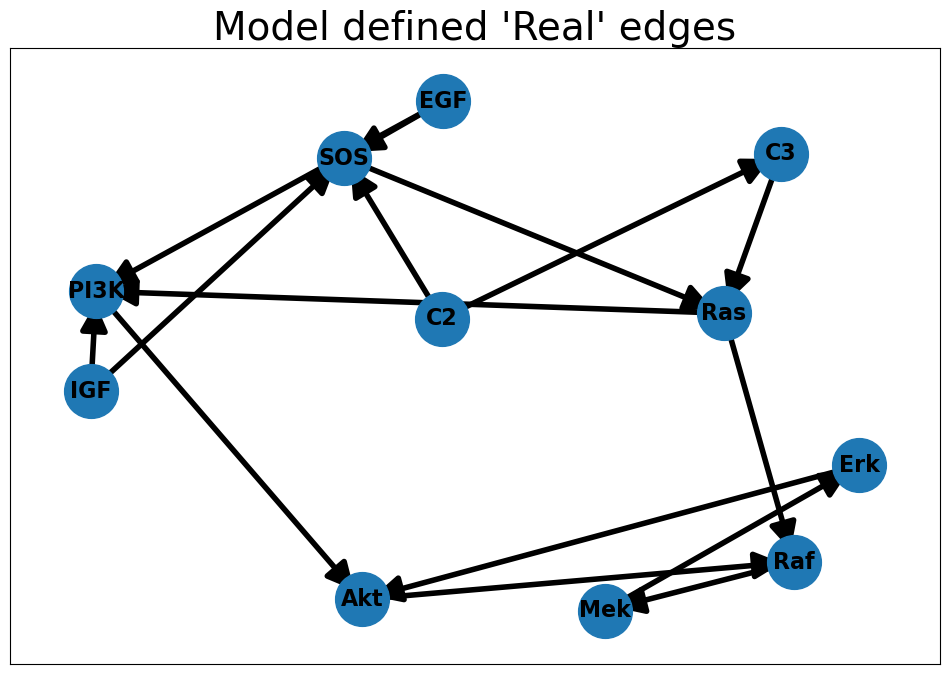

In [158]:
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="black", arrows=True, width=4, arrowsize=40)

ax.set_title("Model defined 'Real' edges", size=28)

In [561]:
means

DeviceArray([-2.1687772 , -0.22227551], dtype=float32)

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

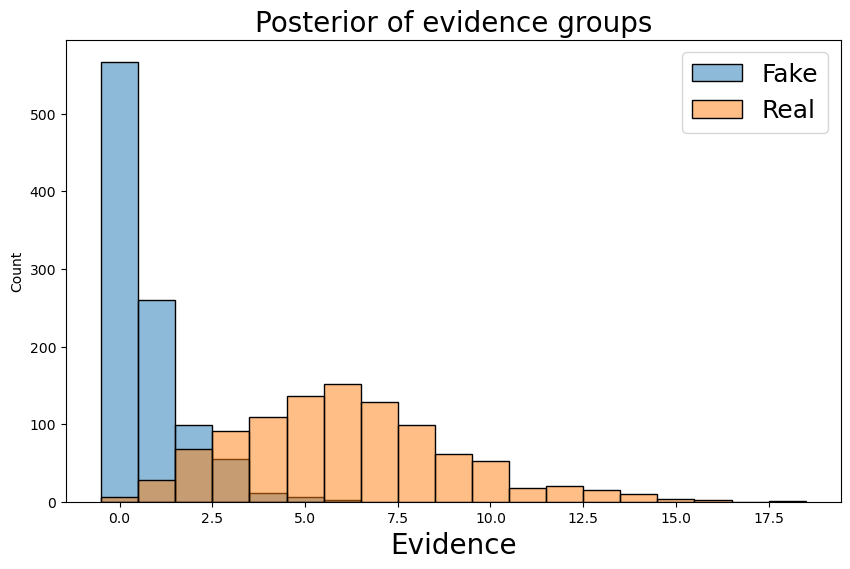

In [20]:
means = mcmc.get_samples()['p_A'].mean(axis=0)
variances = mcmc.get_samples()['p_B'].mean(axis=0)

fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(np.random.poisson(np.random.gamma(means[0], 1/variances[0], 1000)), ax=ax, discrete=True, alpha=.5, label="Fake")
sns.histplot(np.random.poisson(np.random.gamma(means[1], 1/variances[1], 1000)), ax=ax, discrete=True, alpha=.5, label="Real")
ax.set_title("Posterior of evidence groups", size=20)
ax.set_xlabel("Evidence", size=20)
plt.legend(fontsize=18)

### Data + INDRA

In [159]:
def model(indra_data, corr_data, n_edges, data_mask):
    
    p_Adata = numpyro.sample("p_Adata", dist.Normal(jnp.array([-2, -.5]), jnp.array([.5, .5])).to_event(1))
    p_Bdata = numpyro.sample("p_Bdata", dist.Normal(jnp.array([1, 1]), jnp.array([.25,.25])).to_event(1))
    
    p_Aindra = numpyro.sample("p_Aindra", dist.LogNormal(jnp.array([1, 5]), jnp.array([.5, .5])).to_event(1))
    p_Bindra = numpyro.sample("p_Bindra", dist.LogNormal(jnp.array([.5, .5]), jnp.array([.25,.25])).to_event(1))
    
    with numpyro.plate("data_plate", n_edges):
        edge_priors = numpyro.sample("edge_probs", dist.Beta(1, 1))

        present_sample = numpyro.sample("sample_edge", 
                                        dist.Bernoulli(edge_priors),
                                       infer={'enumerate': 'parallel'})

        numpyro.sample("indra_evidence", dist.GammaPoisson(Vindex(p_Aindra)[present_sample],
                                                                Vindex(p_Bindra)[present_sample]), 
                       obs=indra_data)

        numpyro.sample("corr_evidence", dist.LogNormal(Vindex(p_Adata)[present_sample],
                                                       Vindex(p_Bdata)[present_sample]).mask(data_mask), 
                       obs=corr_data)


In [160]:
indra_graph = indra_graph.reset_index(drop=True)

In [161]:
mask = list()
corr_obs = list()
for i in range(len(indra_graph)):
    test = indra_graph.loc[i, ["From", "To"]]
    test = corr_mat.loc[(corr_mat["From"] == test["From"]) & (corr_mat["To"] == test["To"])]
    if len(test) == 0:
        mask.append(False)
        corr_obs.append(0)
    else:
        mask.append(True)
        corr_obs.append(test["Correlation"].values[0])

In [162]:
mcmc = MCMC(NUTS(model), num_warmup=10000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(1), indra_graph["evidence"].values, np.array(corr_obs), len(indra_graph), np.array(mask))

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

In [163]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 edge_probs[0]      0.56      0.28      0.59      0.14      1.00   4119.35      1.00
 edge_probs[1]      0.66      0.24      0.70      0.31      1.00   3408.34      1.00
 edge_probs[2]      0.67      0.24      0.72      0.31      1.00   4059.30      1.00
 edge_probs[3]      0.56      0.28      0.59      0.14      1.00   3128.53      1.00
 edge_probs[4]      0.67      0.23      0.71      0.32      1.00   3407.76      1.00
 edge_probs[5]      0.66      0.24      0.70      0.30      1.00   2967.28      1.00
 edge_probs[6]      0.64      0.25      0.68      0.26      1.00   2925.63      1.00
 edge_probs[7]      0.67      0.23      0.70      0.32      1.00   3890.06      1.00
 edge_probs[8]      0.46      0.29      0.44      0.00      0.88   1975.41      1.00
 edge_probs[9]      0.67      0.24      0.71      0.31      1.00   2696.78      1.00
edge_probs[10]      0.67      0.23      0.71      0.33      1.00

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Edge probability')

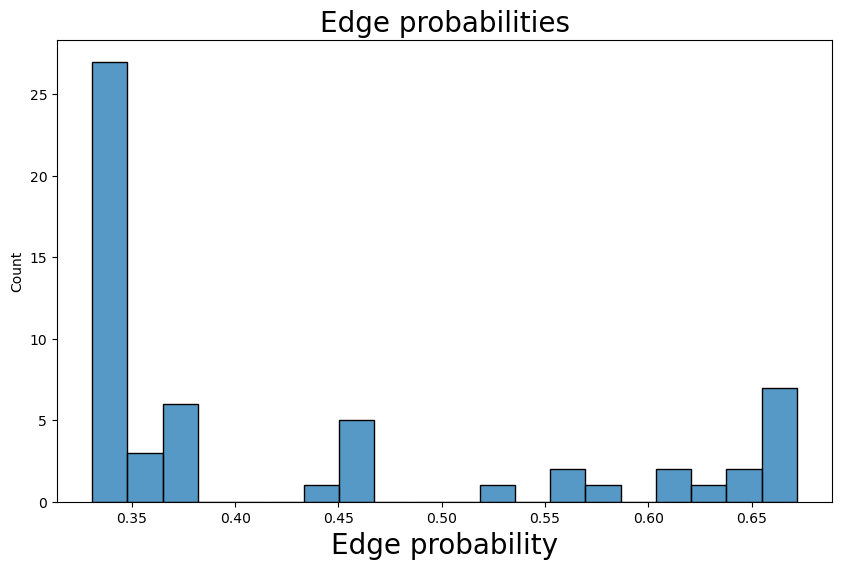

In [164]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(mcmc.get_samples()['edge_probs'].mean(axis=0), bins=20)
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge probability", size=20)

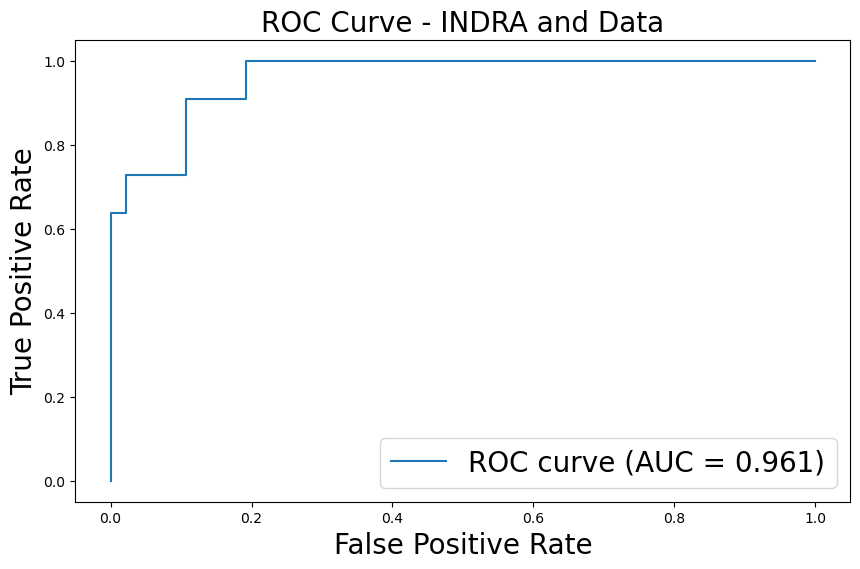

In [165]:
# Generate some data
y_true = indra_graph["real"].values.astype(float)
y_score = np.array(mcmc.get_samples()['edge_probs'].mean(axis=0))

fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC
auc_score = roc_auc_score(y_true, y_score)

# Plot the ROC curve
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(fpr, tpr, label='ROC curve (AUC = %.3f)' % auc_score)
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.title('ROC Curve - INDRA and Data', size=20)
plt.legend(loc='lower right', fontsize=20)
plt.show()

In [943]:
fpr, tpr, thresholds 

(array([0.        , 0.        , 0.        , 0.01666667, 0.01666667,
        0.16666667, 0.16666667, 1.        ]),
 array([0.        , 0.11111111, 0.66666667, 0.66666667, 0.88888889,
        0.88888889, 1.        , 1.        ]),
 array([1.6710241 , 0.6710241 , 0.65321195, 0.65305936, 0.6328347 ,
        0.4945824 , 0.4521997 , 0.32857102], dtype=float32))

In [167]:
id_edges = indra_graph[np.array(mcmc.get_samples()['edge_probs'].mean(axis=0) > 0.5)].reset_index(drop=True)

In [168]:
G = nx.DiGraph()
indra_edges = id_edges.reset_index(drop=True)
for i in range(len(id_edges)):
    G.add_edge(id_edges.loc[i, "From"],
                   id_edges.loc[i, "To"])
#                , latent=id_edges.loc[i, "color"])
# colors = nx.get_edge_attributes(G,'latent').values()


/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Text(0.5, 1.0, "Model defined 'Real' edges")

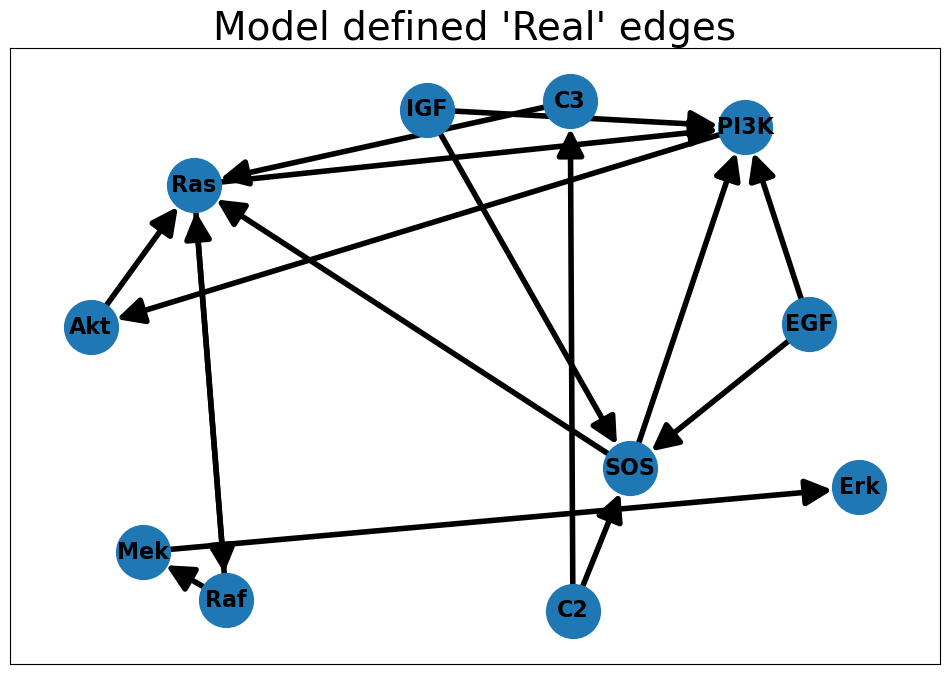

In [169]:
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="black", arrows=True, width=4, arrowsize=40, node_size = 1500)

ax.set_title("Model defined 'Real' edges", size=28)

### Directionality-based weighting

In [170]:
indra_diff = list()
con_list = list()
for i in combinations(obs_nodes, 2):
    first = indra_graph.loc[(indra_graph["From"] == i[0]) & (indra_graph["To"] == i[1])]#, "evidence"].values[0]
    second = indra_graph.loc[(indra_graph["From"] == i[1]) & (indra_graph["To"] == i[0])]#, "evidence"].values[0]
    con_list.append(first)
    con_list.append(second)
    if (len(first) != 0) & (len(second) != 0):
        first_val = first["evidence"].values[0]
        second_val = second["evidence"].values[0]    
        indra_diff.append(first_val - second_val)
        indra_diff.append(second_val - first_val)
    elif (len(first) == 0) & (len(second) != 0):
        second_val = second["evidence"].values[0]    
        indra_diff.append(second_val)
    elif (len(first) != 0) & (len(second) == 0):
        first_val = first["evidence"].values[0]
        indra_diff.append(first_val)
        
indra_diff = np.array(indra_diff)
weight_list = pd.concat(con_list, ignore_index=True)
weight_list.loc[:, "diffs"] = (indra_diff - min(indra_diff) + .001)/(max(indra_diff) - min(indra_diff))

In [171]:
mask = list()
corr_obs = list()
weights_full = list()
for i in range(len(indra_graph)):
    test = indra_graph.loc[i, ["From", "To"]]
    test = corr_mat.loc[(corr_mat["From"] == test["From"]) & (corr_mat["To"] == test["To"])]
    if len(test) == 0:
        mask.append(False)
        corr_obs.append(0)
        weights_full.append(1.)
    else:
        mask.append(True)
        corr_obs.append(test["Correlation"].values[0])
        weights_full.append(weight_list.loc[(weight_list["From"].values == test["From"].values) & (weight_list["To"].values == test["To"].values), "diffs"].values[0])

In [172]:
def model(indra_data, corr_data, n_edges, data_mask, w):
    
    p_Adata = numpyro.sample("p_Adata", dist.Normal(jnp.array([-2, -.5]), jnp.array([.5, .5])).to_event(1))
    p_Bdata = numpyro.sample("p_Bdata", dist.Normal(jnp.array([1, 1]), jnp.array([.25,.25])).to_event(1))
    
    p_Aindra = numpyro.sample("p_Aindra", dist.LogNormal(jnp.array([1, 5]), jnp.array([.5, .5])).to_event(1))
    p_Bindra = numpyro.sample("p_Bindra", dist.LogNormal(jnp.array([.5, .5]), jnp.array([.25,.25])).to_event(1))
    
    with numpyro.plate("data_plate", n_edges):
        edge_priors = numpyro.sample("edge_probs", dist.Beta(1, 1))

        present_sample = numpyro.sample("sample_edge", 
                                        dist.Bernoulli(edge_priors),
                                       infer={'enumerate': 'parallel'})

    with numpyro.plate("data_plate", n_edges), numpyro.handlers.scale(scale=w):
        numpyro.sample("indra_evidence", dist.GammaPoisson(Vindex(p_Aindra)[present_sample],
                                                                Vindex(p_Bindra)[present_sample]), 
                       obs=indra_data)
        numpyro.sample("corr_evidence", dist.LogNormal(Vindex(p_Adata)[present_sample],
                                                       Vindex(p_Bdata)[present_sample]).mask(data_mask), 
                       obs=corr_data)


In [173]:
mcmc = MCMC(NUTS(model), num_warmup=5000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), indra_graph["evidence"].values, 
         np.array(corr_obs), len(indra_graph), np.array(mask), np.array(weights_full))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [719]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 edge_probs[0]      0.54      0.29      0.57      0.13      1.00   6900.66      1.00
 edge_probs[1]      0.34      0.23      0.31      0.00      0.68   7551.58      1.00
 edge_probs[2]      0.34      0.24      0.29      0.00      0.71   7323.78      1.00
 edge_probs[3]      0.66      0.24      0.71      0.31      1.00   9011.87      1.00
 edge_probs[4]      0.67      0.24      0.71      0.31      1.00   8957.08      1.00
 edge_probs[5]      0.67      0.24      0.71      0.32      1.00   8416.09      1.00
 edge_probs[6]      0.67      0.24      0.71      0.32      1.00   8779.86      1.00
 edge_probs[7]      0.67      0.24      0.71      0.31      1.00   8905.95      1.00
 edge_probs[8]      0.61      0.27      0.66      0.21      1.00   6892.62      1.00
 edge_probs[9]      0.67      0.23      0.71      0.34      1.00  10080.07      1.00
edge_probs[10]      0.66      0.24      0.71      0.30      1.00

/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Edge probability')

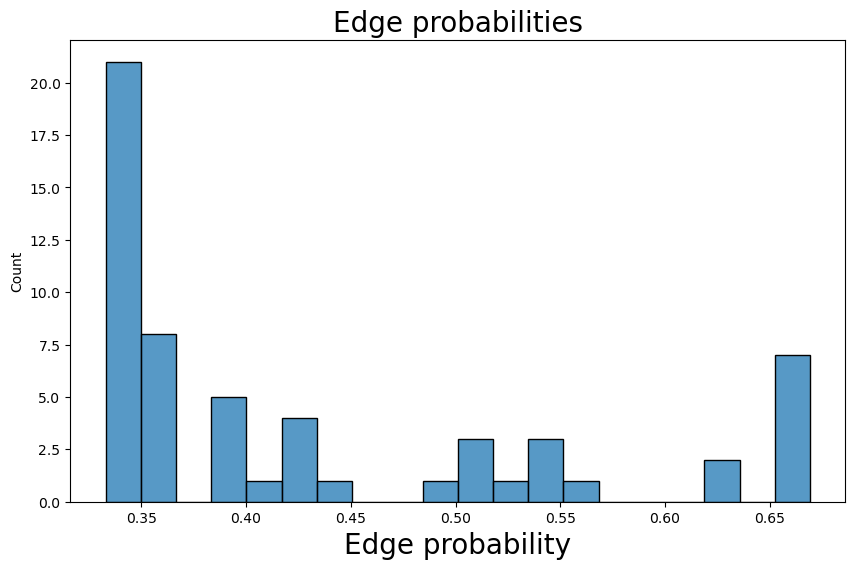

In [175]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(mcmc.get_samples()['edge_probs'].mean(axis=0), bins=20)
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge probability", size=20)

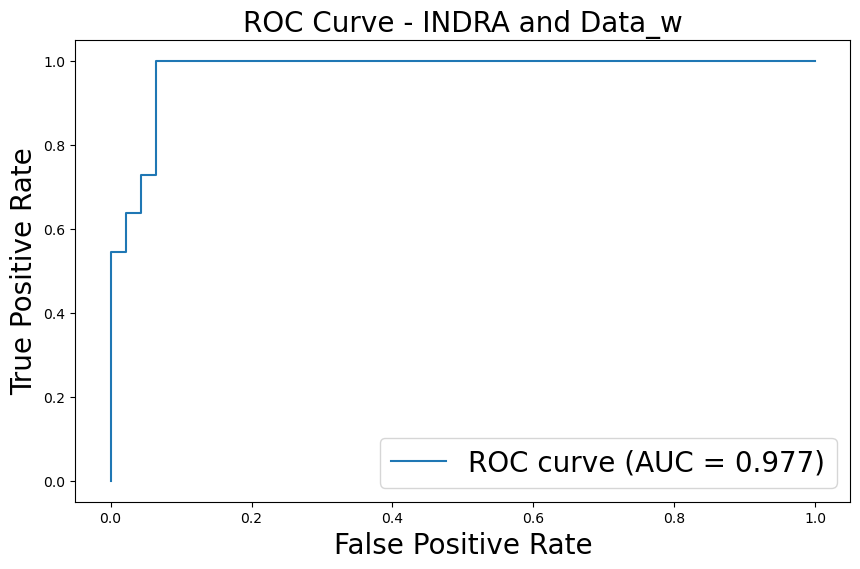

In [177]:
# Generate some data
y_true = indra_graph["real"].values.astype(float)
y_score = np.array(mcmc.get_samples()['edge_probs'].mean(axis=0))

fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC
auc_score = roc_auc_score(y_true, y_score)

# Plot the ROC curve
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(fpr, tpr, label='ROC curve (AUC = %.3f)' % auc_score)
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.title('ROC Curve - INDRA and Data_w', size=20)
plt.legend(loc='lower right', fontsize=20)
plt.show()

In [178]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.0212766 , 0.0212766 ,
        0.04255319, 0.04255319, 0.06382979, 0.06382979, 1.        ]),
 array([0.        , 0.09090909, 0.54545455, 0.54545455, 0.63636364,
        0.63636364, 0.72727273, 0.72727273, 1.        , 1.        ]),
 array([       inf, 0.669182  , 0.6626492 , 0.659462  , 0.6334036 ,
        0.6187539 , 0.56067026, 0.5440895 , 0.5335784 , 0.3328779 ],
       dtype=float32))

In [192]:
id_edges = indra_graph[np.array(mcmc.get_samples()['edge_probs'].mean(axis=0) > .52)].reset_index(drop=True)

In [193]:
id_edges

,From,To,evidence,real
0,EGF,SOS,3,True
1,EGF,PI3K,9,True
2,IGF,SOS,9,True
3,IGF,PI3K,3,True
4,SOS,Ras,7,True
5,Ras,PI3K,5,True
6,Ras,Raf,4,True
7,PI3K,Akt,9,True
8,Akt,Raf,6,True
9,Raf,Mek,15,True


In [194]:
G = nx.DiGraph()
indra_edges = id_edges.reset_index(drop=True)
for i in range(len(id_edges)):
    G.add_edge(id_edges.loc[i, "From"],
                   id_edges.loc[i, "To"])

Text(0.5, 1.0, "Model defined 'Real' edges")

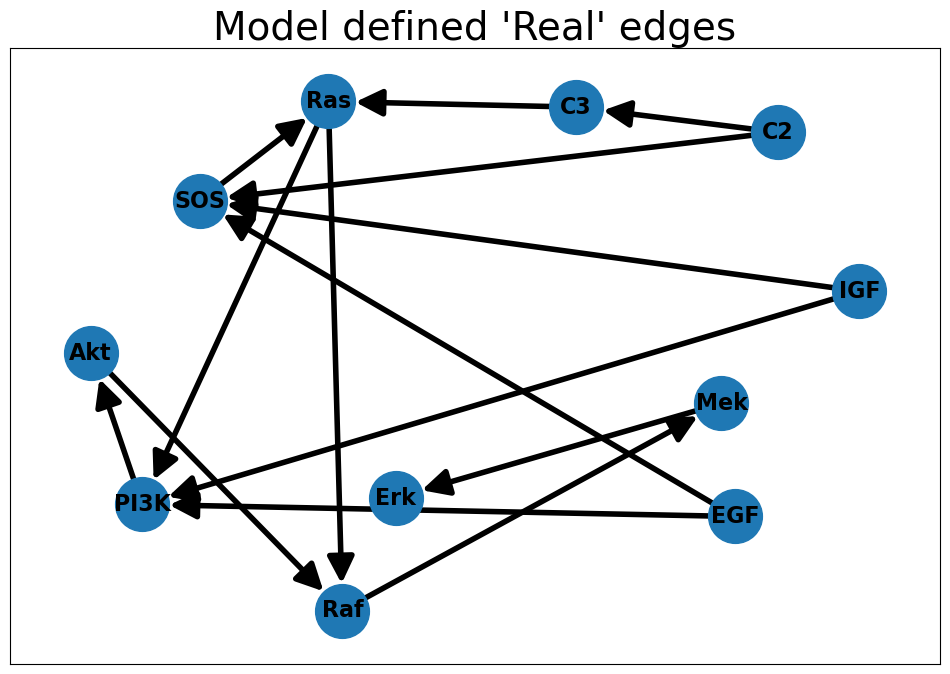

In [198]:
fig, ax = plt.subplots(figsize=(12,8))
# for layer, nodes in enumerate(nx.topological_generations(G)):
#     # `multipartite_layout` expects the layer as a node attribute, so add the
#     # numeric layer value as a node attribute
#     for node in nodes:
#         G.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
# pos = nx.multipartite_layout(G, subset_key="layer")
pos = nx.spring_layout(G, k=2, iterations=20)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, width=4, arrowsize=40, node_size = 1500)

ax.set_title("Model defined 'Real' edges", size=28)

In [197]:
[i for i in nx.simple_cycles(G)]

[]

### Conditional independence (via PC algorithm)

#### Manual

In [630]:
from pgmpy.estimators import CITests
import copy

results = dict()
stop_double_testings = 1
for r in range(len(obs_nodes)):
    r_rez = dict()
    for l in range(stop_double_testings, len(obs_nodes)):
        l_rez = list()
        l_rez.append([])
        
        potential_c = [i for i in obs_nodes if i not in [obs_nodes[r], obs_nodes[l]]]
        
        for n in range(1,len(potential_c)):
            l_rez.append([i for i in combinations(potential_c, r=n)])
        r_rez[obs_nodes[l]] = l_rez
        
    results[obs_nodes[r]] = r_rez
    stop_double_testings+=1

ci_results = dict()
for r in obs_nodes:
    for l in results[r]:
        for c in results[r][l]:
            if len(c) == 0:
                nodes = list()
                nodes.append(r)
                nodes.append(l)
                ci_test = CITests.pearsonr(X=r, Y=l, Z=[], data=sim_data.loc[:, nodes].dropna(), boolean=False)
                ci_results[(r, l, None)] = ci_test
            else:
                for i in c:
                    nodes = list()
                    nodes.extend(list(i))
                    nodes.append(r)
                    nodes.append(l)
                    ci_test = CITests.pearsonr(X=r, Y=l, Z=list(i), data=sim_data.loc[:, nodes].dropna(), boolean=False)
                    ci_results[(r, l, i)] = ci_test

#### Auto

In [747]:
from pgmpy.estimators import PC

In [748]:
test = PC(data=sim_data.dropna())

In [749]:
test_dag = test.estimate(ci_test="pearsonr", return_type ="pdag")

  0%|          | 0/5 [00:00<?, ?it/s]

In [750]:
test_dag.edges

OutEdgeView([('Erk', 'Ras'), ('Erk', 'Mek'), ('PI3K', 'Ras'), ('PI3K', 'SOS'), ('PI3K', 'Akt'), ('SOS', 'PI3K'), ('Raf', 'Mek'), ('Mek', 'Erk'), ('Mek', 'Raf'), ('Akt', 'PI3K')])

In [751]:
one_direct = 1
c_edges= list()
for i in test_dag.edges:
    for j in range(one_direct, len(test_dag.edges)):
        if i != list(test_dag.edges)[j]:
            if (i[0] == list(test_dag.edges)[j][1]) & (i[1] == list(test_dag.edges)[j][0]):
                c_edges.append(i)
    one_direct += 1

In [810]:
c_edges

[('Erk', 'Mek'), ('PI3K', 'SOS'), ('PI3K', 'Akt'), ('Raf', 'Mek')]

In [811]:
list(sum(c_edges, ()))

['Erk', 'Mek', 'PI3K', 'SOS', 'PI3K', 'Akt', 'Raf', 'Mek']

In [755]:
c_w = list()
for i in range(len(indra_graph)):
    if (indra_graph.loc[i, "From_latent"] == True) & (indra_graph.loc[i, "To"] in list(sum(c_edges, ()))):
        c_w.append(2.)
    elif (indra_graph.loc[i, "From_latent"] == True) & (indra_graph.loc[i, "To"] not in list(sum(c_edges, ()))):
        c_w.append(.5)
    else:
        c_w.append(1.)

#### Model

In [763]:
def model(indra_data, corr_data, n_edges, data_mask, w, c_w):
    
    p_Adata = numpyro.sample("p_Adata", dist.Normal(jnp.array([-2, -.5]), jnp.array([.5, .5])).to_event(1))
    p_Bdata = numpyro.sample("p_Bdata", dist.Normal(jnp.array([1, 1]), jnp.array([.25,.25])).to_event(1))
    
    p_Aindra = numpyro.sample("p_Aindra", dist.LogNormal(jnp.array([1, 5]), jnp.array([.5, .5])).to_event(1))
    p_Bindra = numpyro.sample("p_Bindra", dist.LogNormal(jnp.array([.5, .5]), jnp.array([.25,.25])).to_event(1))
    
    with numpyro.plate("data_plate", n_edges):
        edge_priors = numpyro.sample("edge_probs", dist.Beta(1, 1))

        present_sample = numpyro.sample("sample_edge", 
                                        dist.Bernoulli(edge_priors),
                                       infer={'enumerate': 'parallel'})
    
    with numpyro.plate("data_plate", n_edges), numpyro.handlers.scale(scale=w*c_w):
        numpyro.sample("indra_evidence", dist.GammaPoisson(Vindex(p_Aindra)[present_sample],
                                                                Vindex(p_Bindra)[present_sample]), 
                       obs=indra_data)
    with numpyro.plate("data_plate", n_edges), numpyro.handlers.scale(scale=w):
        numpyro.sample("corr_evidence", dist.LogNormal(Vindex(p_Adata)[present_sample],
                                                       Vindex(p_Bdata)[present_sample]).mask(data_mask), 
                       obs=corr_data)


In [766]:
mcmc = MCMC(NUTS(model), num_warmup=20000, num_samples=2000, num_chains=4)
mcmc.run(jax.random.PRNGKey(1), indra_graph["evidence"].values, 
         np.array(corr_obs), len(indra_graph), np.array(mask), np.array(weights_full), np.array(c_w))

  0%|          | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/22000 [00:00<?, ?it/s]

In [767]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 edge_probs[0]      0.63      0.26      0.68      0.25      1.00  14574.38      1.00
 edge_probs[1]      0.33      0.23      0.29      0.00      0.68  17667.70      1.00
 edge_probs[2]      0.34      0.24      0.29      0.00      0.69  17379.27      1.00
 edge_probs[3]      0.67      0.24      0.71      0.32      1.00  21278.29      1.00
 edge_probs[4]      0.67      0.24      0.71      0.32      1.00  16989.81      1.00
 edge_probs[5]      0.67      0.24      0.71      0.31      1.00  17126.20      1.00
 edge_probs[6]      0.67      0.23      0.71      0.33      1.00  18537.81      1.00
 edge_probs[7]      0.67      0.24      0.71      0.31      1.00  18490.00      1.00
 edge_probs[8]      0.63      0.26      0.68      0.25      1.00  14404.79      1.00
 edge_probs[9]      0.67      0.23      0.71      0.32      1.00  18142.99      1.00
edge_probs[10]      0.67      0.24      0.70      0.32      1.00

(array([35.,  4.,  6.,  2.,  0.,  2.,  1.,  1.,  0.,  1.,  2.,  0.,  1.,
         2.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
         7.]),
 array([0.33172774, 0.34014958, 0.34857139, 0.35699323, 0.36541504,
        0.37383687, 0.38225868, 0.39068052, 0.39910233, 0.40752417,
        0.41594601, 0.42436782, 0.43278965, 0.44121146, 0.4496333 ,
        0.45805511, 0.46647695, 0.47489876, 0.48332059, 0.4917424 ,
        0.50016427, 0.50858605, 0.51700789, 0.52542973, 0.53385156,
        0.54227334, 0.55069518, 0.55911702, 0.56753886, 0.57596064,
        0.58438247, 0.59280431, 0.60122615, 0.60964799, 0.61806977,
        0.62649161, 0.63491344, 0.64333528, 0.65175706, 0.6601789 ,
        0.66860074]),
 <BarContainer object of 40 artists>)

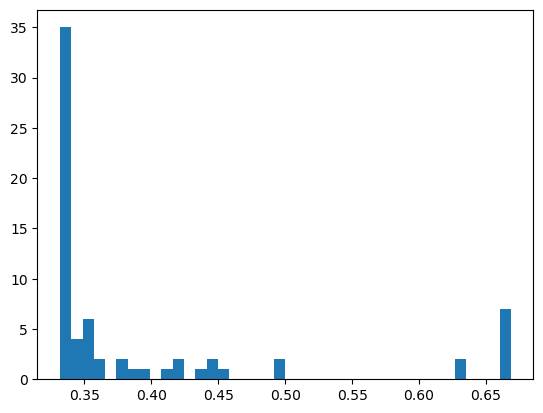

In [768]:
plt.hist(mcmc.get_samples()['edge_probs'].mean(axis=0), bins=40)

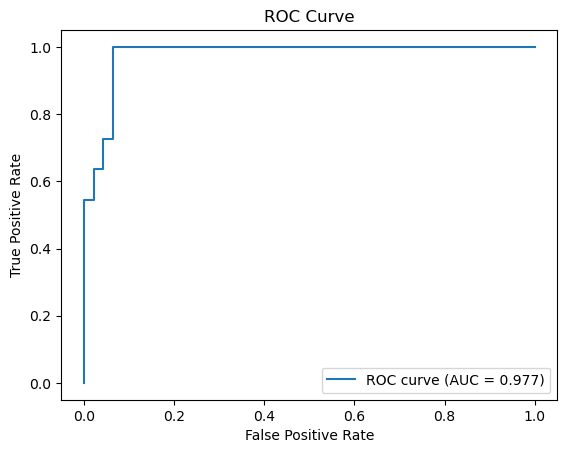

In [199]:
# Generate some data
y_true = indra_graph["real"].values.astype(float)
y_score = np.array(mcmc.get_samples()['edge_probs'].mean(axis=0))

fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC
auc_score = roc_auc_score(y_true, y_score)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %.3f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [683]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.36206897, 0.36206897,
        0.37931034, 0.37931034, 1.        ]),
 array([0.        , 0.09090909, 0.81818182, 0.81818182, 0.90909091,
        0.90909091, 1.        , 1.        ]),
 array([1.6725893 , 0.67258924, 0.6254532 , 0.4362643 , 0.42210394,
        0.41892958, 0.4168622 , 0.3340503 ], dtype=float32))

In [770]:
id_edges = indra_graph[np.array(mcmc.get_samples()['edge_probs'].mean(axis=0) > .5)].reset_index(drop=True)

In [771]:
id_edges

,From,To,evidence,real,From_latent
0,EGF,SOS,5,True,True
1,IGF,PI3K,12,True,True
2,SOS,Ras,15,True,False
3,Ras,PI3K,14,True,False
4,Ras,Raf,14,True,False
5,PI3K,Akt,11,True,False
6,Akt,Raf,9,True,False
7,Raf,Mek,19,True,False
8,Mek,Erk,9,True,False
9,PI3K,Ras,0,False,False


In [772]:
G = nx.DiGraph()
for i in range(len(id_edges)):
    G.add_edge(id_edges.loc[i, "From"], id_edges.loc[i, "To"])

/Users/kohler.d/.conda/envs/MSbayesImp/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


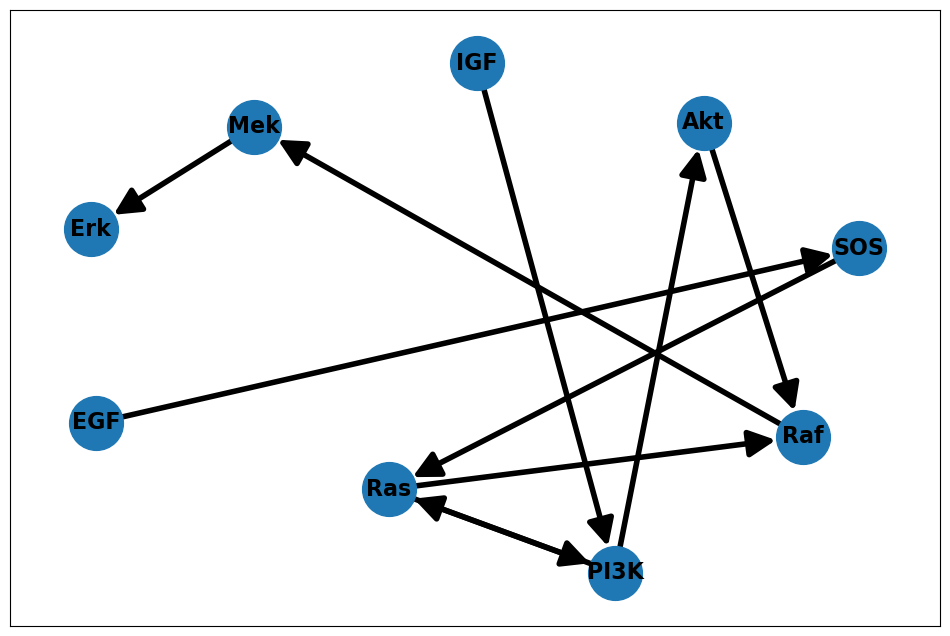

In [773]:
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G, k=2, iterations=20)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, width=4, arrowsize=40, node_size = 1500)

In [698]:
indra_graph[indra_graph["From"] == "EGF"]

,From,To,evidence,real,From_latent
0,EGF,SOS,5,True,True
1,EGF,PI3K,2,True,True
44,EGF,Raf,0,False,True
45,EGF,IGF,1,False,True
46,EGF,C1,1,False,True
47,EGF,C2,3,False,True


In [663]:
[i for i in nx.simple_cycles(G)]

[]

## Real data

### SOX11 TF Gene Set

In [104]:
filename = "../data/INDRA_networks/SOX11_TARGET_GENES.tsv"

gene_set = pd.read_csv(filename, sep="\t")#.loc[:, 
       # ["source_hgnc_symbol", "target_hgnc_symbol", "evidence_count"]]

<Axes: >

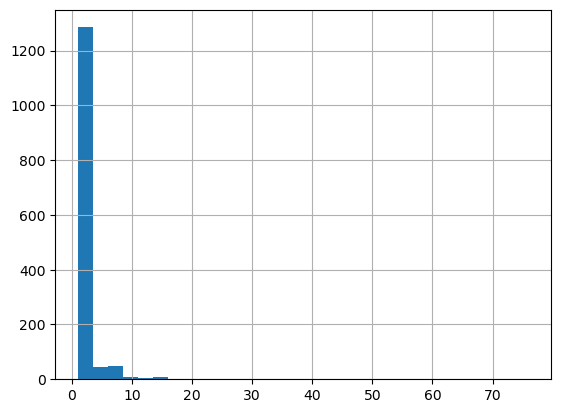

In [105]:
gene_set["evidence_count"].hist(bins=30)

<Axes: >

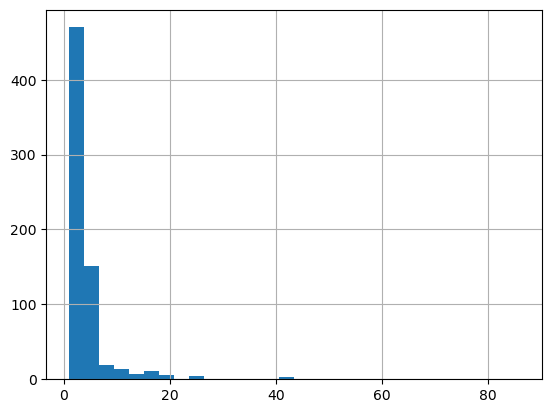

In [106]:
gene_set = gene_set.groupby(['source_hgnc_symbol', 'target_hgnc_symbol'])["evidence_count"].sum().reset_index()
# gene_set[gene_set[['source_hgnc_symbol', 'target_hgnc_symbol']].duplicated()]
gene_set["evidence_count"].hist(bins=30)

#### INDRA only

/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_80370/3286027069.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  plt.plot(np.arange(.01,5,.01), [np.sqrt(i/(1-i)) for i in np.arange(.01,5,.01)])
/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_80370/3286027069.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.arange(.01,5,.01), [np.sqrt(i/(1-i)) for i in np.arange(.01,5,.01)])


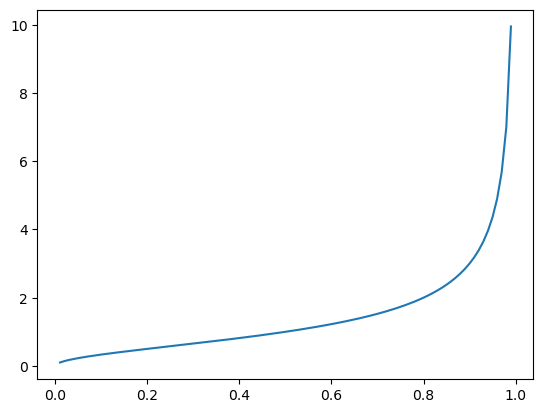

In [79]:
plt.plot(np.arange(.01,5,.01), [np.sqrt(i/(1-i)) for i in np.arange(.01,5,.01)])

In [93]:
def model(data, n_edges):
        
    # p_A = numpyro.sample("p_A", dist.LogNormal(jnp.array([0, 2]), jnp.array([.5, .5])).to_event(1))
    # p_B = numpyro.sample("p_B", dist.LogNormal(jnp.array([-1, 1]), jnp.array([1, 1])).to_event(1))
    
    with numpyro.plate("data_plate", n_edges):
        edge_priors = numpyro.sample("edge_probs", dist.Beta(1, 5))
        link = jnp.sqrt(edge_priors/(1-edge_priors))
        numpyro.sample("indra_evidence", dist.GammaPoisson(link, 1.), obs=data)
    

In [94]:
mcmc = MCMC(NUTS(model), num_warmup=20000, num_samples=2500, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), gene_set["evidence_count"].values-1, len(gene_set))

  0%|          | 0/22500 [00:00<?, ?it/s]

  0%|          | 0/22500 [00:00<?, ?it/s]

  0%|          | 0/22500 [00:00<?, ?it/s]

  0%|          | 0/22500 [00:00<?, ?it/s]

In [96]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  edge_probs[0]      0.29      0.18      0.27      0.01      0.55  16961.99      1.00
  edge_probs[1]      0.29      0.18      0.26      0.01      0.55  16895.94      1.00
  edge_probs[2]      0.26      0.17      0.24      0.01      0.51  18488.17      1.00
  edge_probs[3]      0.22      0.15      0.19      0.00      0.43  18472.47      1.00
  edge_probs[4]      0.14      0.13      0.11      0.00      0.33  14733.75      1.00
  edge_probs[5]      0.14      0.13      0.11      0.00      0.32  17126.57      1.00
  edge_probs[6]      0.15      0.13      0.11      0.00      0.33  16334.97      1.00
  edge_probs[7]      0.31      0.18      0.28      0.02      0.57  19418.47      1.00
  edge_probs[8]      0.14      0.13      0.11      0.00      0.33  16281.15      1.00
  edge_probs[9]      0.28      0.17      0.25      0.01      0.52  18014.27      1.00
 edge_probs[10]      0.22      0.15      0.19      0.

Text(0, 0.5, 'Edge probability')

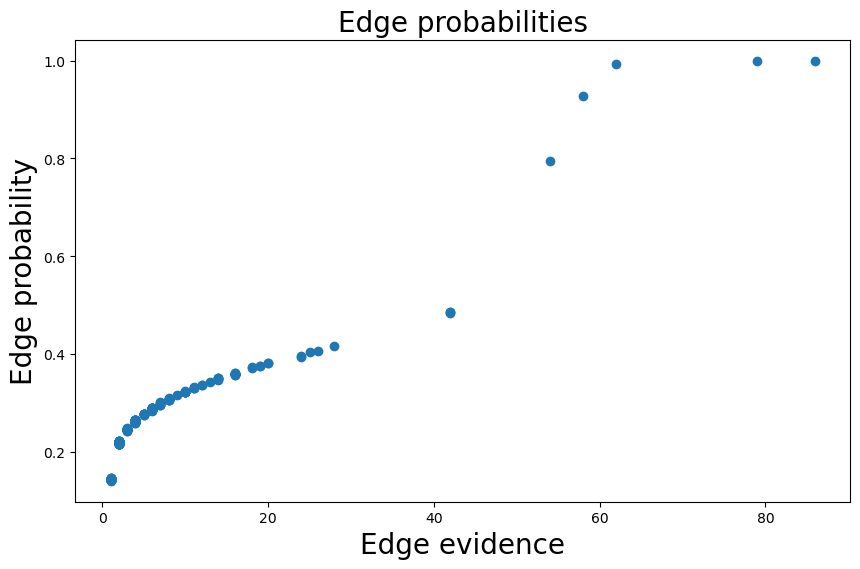

In [95]:
fig, ax = plt.subplots(figsize = (10,6))

ax.scatter(gene_set["evidence_count"].values, mcmc.get_samples()['edge_probs'].mean(axis=0))
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge evidence", size=20)
ax.set_ylabel("Edge probability", size=20)

Text(0.5, 0, 'Edge probability')

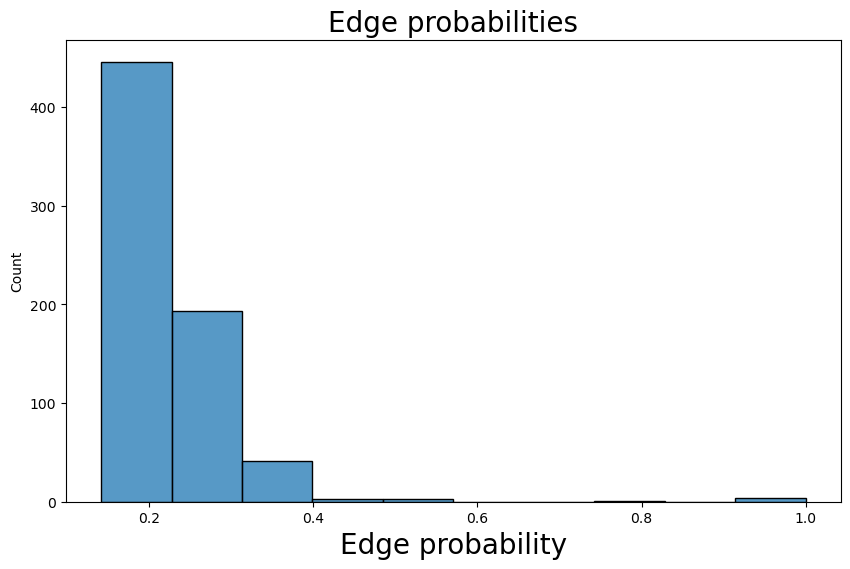

In [98]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(mcmc.get_samples()['edge_probs'].mean(axis=0), bins=10)
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge probability", size=20)

In [110]:
id_edges = gene_set[np.array(mcmc.get_samples()['edge_probs'].mean(axis=0) > 0.33)].reset_index(drop=True)

In [111]:
G = nx.DiGraph()
id_edges = id_edges.reset_index(drop=True)
for i in range(len(id_edges)):
    G.add_edge(id_edges.loc[i, "source_hgnc_symbol"],
                   id_edges.loc[i, "target_hgnc_symbol"])
#     , latent=id_edges.loc[i, "color"])
# colors = nx.get_edge_attributes(G,'latent').values()

Text(0.5, 1.0, "Model defined 'Real' edges")

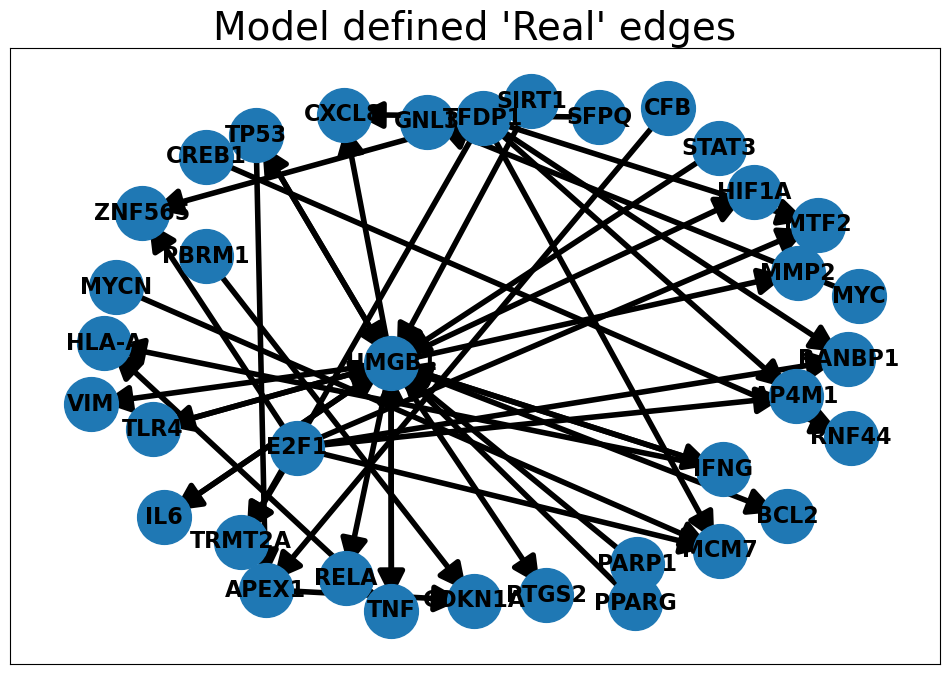

In [112]:
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="black", arrows=True, width=4, arrowsize=40)

ax.set_title("Model defined 'Real' edges", size=28)

#### INDRA + Data

In [113]:
def prep_experimental_data(experimental_data, data_type="TMT", protein_format=None):
    """
    Prepares experimental data for graph building.

    :param data_type: One of 'TMT', 'LFQ'
    :param protein_format: One of None, 'UniProtKB_AC/ID', 'Gene_Namce_Organism'
    :return:
    """
    if data_type == "TMT":
        experimental_data.loc[:, "Run"] = experimental_data.loc[:,"Run"] + "_" + experimental_data.loc[:, "Channel"]

    sexperimental_data = experimental_data.loc[:, ["Protein", "Abundance", "Run"]]

    if protein_format == "UniProtKB_AC/ID":
        experimental_data.loc[:, "Protein"] = experimental_data.loc[:, "Protein"
                                                   ].str.split("|").str[-1].str.split("_").str[0]
    elif protein_format == "Gene_Name_Organism":
        experimental_data.loc[:, "Protein"] = experimental_data.loc[:, "Protein"].str.split("_").str[0]

    experimental_data = experimental_data.groupby(["Protein", "Run"])["Abundance"].sum().reset_index()
    experimental_data = pd.pivot_table(data=experimental_data,
                                            index='Run', columns='Protein',
                                            values='Abundance')
    return experimental_data

In [169]:
experimental_data = pd.read_csv("~/OneDrive - Northeastern University/Northeastern/Research/MS_data/Single_cell/Leduc/MSstats/MSstats_summarized.csv")
data = prep_experimental_data(experimental_data, data_type="TMT", protein_format="UniProtKB_AC/ID")

In [170]:
indra_genes = np.unique(np.concatenate([gene_set.loc[:, 'source_hgnc_symbol'].values, gene_set.loc[:, 'target_hgnc_symbol'].values]))

In [171]:
data = data.loc[:, data.columns.isin(indra_genes)]
data = data.loc[:, pd.isnull(data).sum()/len(data) < .85]

In [172]:
data.columns.name = None
corr_mat = abs(data.corr())
corr_mat = corr_mat.stack().reset_index()
corr_mat.columns = ["From", "To", "Correlation"]
corr_mat = corr_mat.loc[-(corr_mat["From"] == corr_mat["To"])].reset_index(drop=True)

<Axes: >

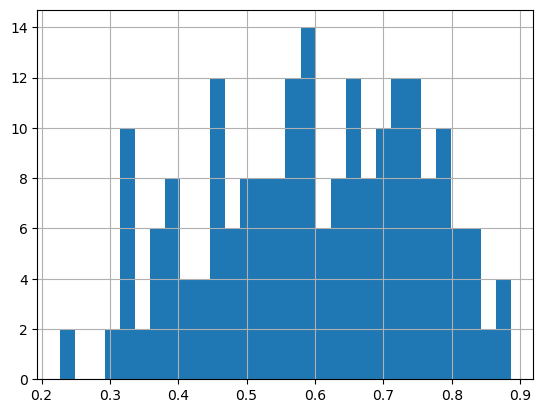

In [174]:
corr_mat["Correlation"].hist(bins=30)

In [186]:
def model(indra_data, corr_data, n_edges, data_mask):
    
    p_Adata = numpyro.sample("p_Adata", dist.Normal(jnp.array([-2, -.5]), jnp.array([.5, .5])).to_event(1))
    p_Bdata = numpyro.sample("p_Bdata", dist.Normal(jnp.array([1, 1]), jnp.array([.25,.25])).to_event(1))
    
    p_B = numpyro.sample("p_B", dist.LogNormal(.5, .25))
    
    with numpyro.plate("data_plate", n_edges):
        edge_priors = numpyro.sample("edge_probs", dist.Beta(1, 5))

        present_sample = numpyro.sample("sample_edge", 
                                        dist.Bernoulli(edge_priors),
                                       infer={'enumerate': 'parallel'})

        link = jnp.sqrt(edge_priors/(1-edge_priors))
        numpyro.sample("indra_evidence", dist.GammaPoisson(link, p_B), obs=indra_data)

        numpyro.sample("corr_evidence", dist.LogNormal(Vindex(p_Adata)[present_sample],
                                                       Vindex(p_Bdata)[present_sample]).mask(data_mask), 
                       obs=corr_data)


In [189]:
gene_set = gene_set.reset_index(drop=True)

In [202]:
mask = list()
corr_obs = list()
for i in range(len(gene_set)):
    test = gene_set.loc[i, ["source_hgnc_symbol", "target_hgnc_symbol"]]
    test = corr_mat.loc[(corr_mat["From"] == test["source_hgnc_symbol"]) & (corr_mat["To"] == test["target_hgnc_symbol"])]
    if len(test) == 0:
        mask.append(False)
        corr_obs.append(0)
    else:
        mask.append(True)
        corr_obs.append(test["Correlation"].values[0])

In [191]:
mcmc = MCMC(NUTS(model), num_warmup=10000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(1), gene_set["evidence_count"].values, np.array(corr_obs), len(gene_set), np.array(mask))

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

In [192]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  edge_probs[0]      0.23      0.14      0.20      0.00      0.43   5953.35      1.00
  edge_probs[1]      0.23      0.15      0.20      0.00      0.44   5898.57      1.00
  edge_probs[2]      0.22      0.15      0.19      0.00      0.42   6816.04      1.00
  edge_probs[3]      0.19      0.13      0.16      0.00      0.38   6422.23      1.00
  edge_probs[4]      0.17      0.12      0.14      0.00      0.35   5249.25      1.00
  edge_probs[5]      0.17      0.13      0.15      0.00      0.35   5778.38      1.00
  edge_probs[6]      0.18      0.13      0.15      0.00      0.35   5599.49      1.00
  edge_probs[7]      0.24      0.15      0.22      0.01      0.47   5452.65      1.00
  edge_probs[8]      0.17      0.13      0.14      0.00      0.35   5700.81      1.00
  edge_probs[9]      0.22      0.15      0.19      0.01      0.43   5201.29      1.00
 edge_probs[10]      0.19      0.14      0.16      0.

Text(0.5, 0, 'Edge probability')

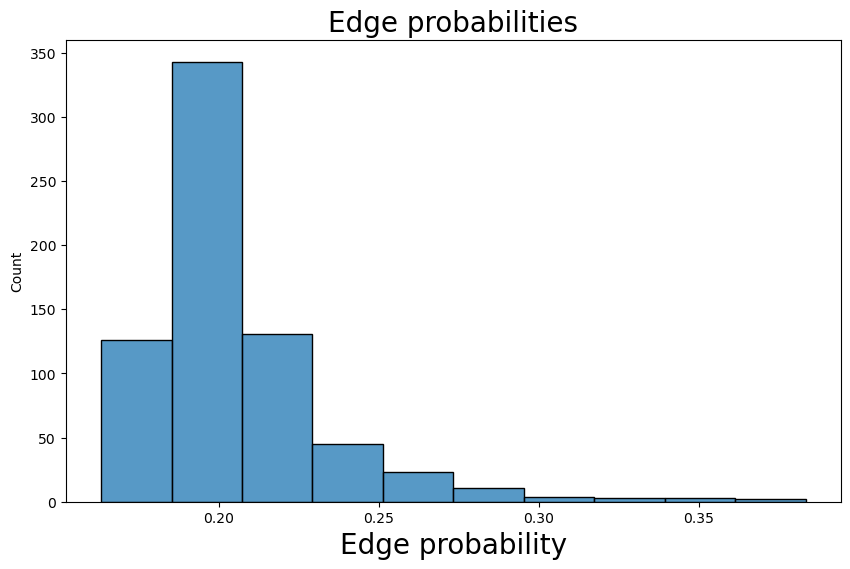

In [193]:
fig, ax = plt.subplots(figsize = (10,6))

sns.histplot(mcmc.get_samples()['edge_probs'].mean(axis=0), bins=10)
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge probability", size=20)

Text(0, 0.5, 'Edge probability')

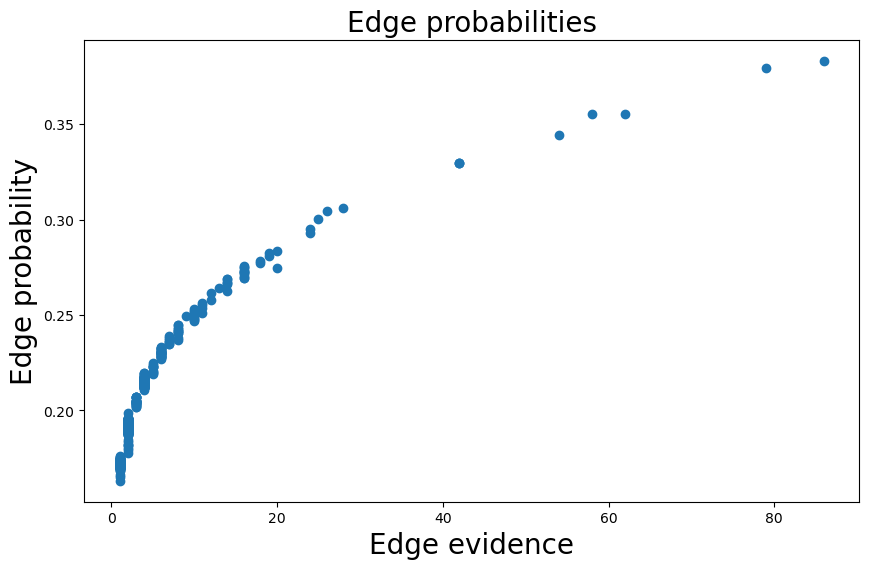

In [194]:
fig, ax = plt.subplots(figsize = (10,6))

ax.scatter(gene_set["evidence_count"].values, mcmc.get_samples()['edge_probs'].mean(axis=0))
ax.set_title("Edge probabilities", size=20)
ax.set_xlabel("Edge evidence", size=20)
ax.set_ylabel("Edge probability", size=20)

In [195]:
id_edges = gene_set[np.array(mcmc.get_samples()['edge_probs'].mean(axis=0) > 0.3)].reset_index(drop=True)

In [198]:
G = nx.DiGraph()
id_edges = id_edges.reset_index(drop=True)
for i in range(len(id_edges)):
    G.add_edge(id_edges.loc[i, "source_hgnc_symbol"],
                   id_edges.loc[i, "target_hgnc_symbol"])
#     , latent=id_edges.loc[i, "color"])
# colors = nx.get_edge_attributes(G,'latent').values()

Text(0.5, 1.0, "Model defined 'Real' edges")

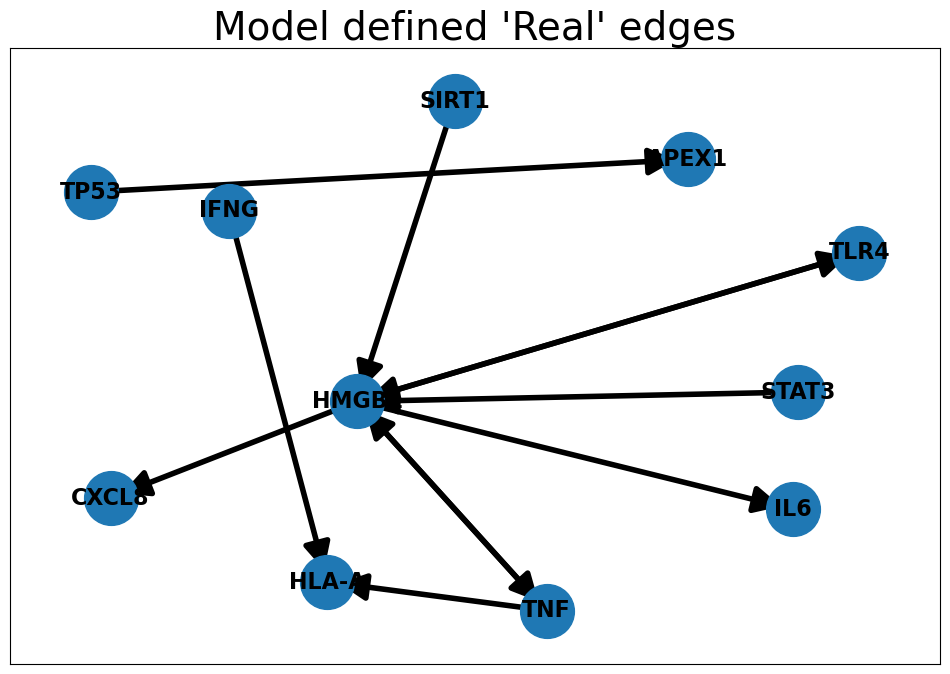

In [199]:
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 1500)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="black", arrows=True, width=4, arrowsize=40)

ax.set_title("Model defined 'Real' edges", size=28)

## Structure learning algorithms (ensemble)

In [25]:
import torch
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

### PC

In [709]:
from pgmpy.estimators import HillClimbSearch, BicScore

In [711]:
est = HillClimbSearch(sim_data)
best_model = est.estimate(scoring_method=BicScore(sim_data))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [712]:
best_model.edges()

OutEdgeView([])

### DAGMA

In [26]:
model = DagmaLinear(loss_type='l2') # create a linear model with least squares loss
W_est = model.fit(sim_data.fillna(sim_data.mean()).values, lambda1=0.02) 

  0%|          | 0/180000.0 [00:00<?, ?it/s]

In [27]:
dagma_graph = pd.DataFrame(W_est, columns=sim_data.columns)
dagma_graph.index = sim_data.columns

In [28]:
dagma_graph

,Akt,Erk,Mek,PI3K,Raf,Ras,SOS
Akt,0.000000,0.000000,0.0,0.848832,0.0,0.000000,0.000000
Erk,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
Mek,0.000000,1.033728,0.0,0.000000,0.0,0.000000,0.000000
PI3K,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.598155
Raf,-0.698892,0.617713,0.0,0.000000,0.0,0.330968,0.000000
Ras,1.062493,0.000000,0.0,0.660505,0.0,0.000000,0.000000
SOS,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [336]:
eq_model = DagmaMLP(dims=[7, 10, 1], bias=True, dtype=torch.double) # create the model for the structural equations, in this case MLPs
model = DagmaNonlinear(eq_model, dtype=torch.double) # create the model for DAG learning
W_est = model.fit(sim_data.fillna(sim_data.mean()).values, lambda1=0.02, lambda2=0.005) # fit the model with L1 reg. (coeff. 0.02) and L2 reg. (coeff. 0.005)


  0%|          | 0/230000.0 [00:00<?, ?it/s]

In [337]:
dagma_graph = pd.DataFrame(W_est, columns=sim_data.columns)
dagma_graph.index = sim_data.columns
dagma_graph

,Akt,Erk,Mek,PI3K,Raf,Ras,SOS
Akt,0.0,0.303829,0.0,0.000000,0.0,0.0,0.0
Erk,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Mek,0.0,0.545021,0.0,0.000000,0.0,0.0,0.0
PI3K,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Raf,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Ras,0.0,0.359797,0.0,0.373767,0.0,0.0,0.0
SOS,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


### SAM

In [338]:
from cdt.causality.graph import SAM

Detecting 1 CUDA device(s).


In [370]:
obj = SAM()

In [371]:
output = obj.predict(sim_data.fillna(sim_data.mean())) 

Process Process-37:
Traceback (most recent call last):
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/cdt/utils/parallel.py", line 54, in worker_subprocess
    output = function(*args, **kwargs, device=device, idx=idx)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/cdt/causality/graph/SAM.py", line 216, in run_SAM
    data = th.from_numpy(data).to(device)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/torch/cuda/__init__.py", line 239, in _lazy_init
    raise AssertionError("Torch not compiled with CUDA 

KeyboardInterrupt: 

Process Process-42:
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process Process-40:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/cdt/utils/parallel.py", line 53, in worker_subprocess
    sleep(1)
Process Process-38:
Traceback (most recent call last):
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line

In [ ]:
nx.draw_networkx(output, font_size=8)

### CGNN

In [343]:
from cdt.causality.graph import CGNN

In [344]:
obj = CGNN()
output = obj.predict(data) 

An exhaustive search of the causal structure of CGNN without skeleton is super-exponential in the number of variables.
A total of 3 graphs will be evaluated.
Process Process-20:
Traceback (most recent call last):
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/cdt/utils/parallel.py", line 54, in worker_subprocess
    output = function(*args, **kwargs, device=device, idx=idx)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/cdt/causality/graph/CGNN.py", line 197, in graph_evaluation
    obs = th.Tensor(scale(data.values)).to(device)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/cdt/utils/parallel.py", line 53, in worker_subprocess
    sleep(1)
KeyboardInterrupt
Process Process-34:
Traceback (most recent call last):
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process Process-32:
Traceback (most recent call last):
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/cdt/utils/parallel.py", line 53, in worker_subprocess
    sleep(1)
KeyboardInterrupt
Process Process-31:
  File "/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/multiprocessing/process.py", l

In [ ]:
nx.draw_networkx(output, font_size=8)

### IAMB

In [368]:
from cdt.causality.pairwise import ANM

In [369]:
obj = ANM()
output = obj.predict(sim_data.fillna(sim_data.mean()))

ValueError: Length mismatch: Expected axis has 7 elements, new values have 2 elements

In [364]:
nx.draw_networkx(output, font_size=8) 

TypeError: 'NoneType' object is not iterable